# TIMESERIES ANALYSIS

# Business Understanding

This project focuses on the application of time series regression analysis to forecast sales for Corporation Favorita, a prominent grocery retailer based in Ecuador.

The primary objective is to develop a robust model capable of accurately forecasting future sales by leveraging the extensive time series data of thousands of products sold across various Favorita locations. The resulting forecasts will provide valuable insights to the store's management, enabling them to formulate effective inventory and sales plans.

Through this research, we will construct models based on historical analysis, establish scientific hypothesis using time-stamped historical data, and employ these models to observe patterns and guide strategic decision-making in the future. By delving into the data, our aim is to optimize operations and ultimately drive sales growth for Favorita Corporation, supporting the management team in extracting meaningful insights from their vast dataset.

# Hypothesis

Null Hypothesis: Sales are not affected by promotion, oil prices and holidays.

Alternate Hypothesis: Sales are affected by promotion, oil prices and holidays.

# Analytical Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

8. What is the total sales made each year by the corporation?

In [1]:
# Installation

# !pip install pyodbc
# !pip install python-dotenv
# !pip install sqlalchemy
# !pip install lightgbm
# !pip install xgboost
# !pip install catboost

In [2]:
# Importing the needed packages
import pandas as pd
import numpy as np
import matplotlib.dates as ndates

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to create connection string to SQL server
import pyodbc
from dotenv import dotenv_values

# Library for imputing missing values
from sklearn.impute import SimpleImputer

# Library for seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Library for checking stationarity
from statsmodels.tsa.stattools import adfuller

# Library for feature scaling
from sklearn.preprocessing import StandardScaler

# Library for feature encoding
from sklearn.preprocessing import OneHotEncoder

# Libraries for modelling

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Libraries for calculating evaluation metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from sklearn.linear_model import LinearRegression

# Library for working with operating system
import os

# Library to handle warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Data Understanding

### Accessing and loading the datasets

The first dataset was collected from a SQL database by first passing a connection string using the pyodbc library. Afterwards a SQL query was used to obtain the dataset. This is as shown below.

In [4]:
# Load the environment variable in the .env file into a dictionary

environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the .env file
server = environment_variables.get('SERVER')
database = environment_variables.get('DATABASE')
username = environment_variables.get('USERNAME')
password = environment_variables.get('PASSWORD')

# The connection string is an f string that includes all the variable above to establish a connection to the server.
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

In [5]:
# Use the connect method of the pyodbc library to pass in the connection string.
# Check your internet connection if it takes more time than necessary.

connection = pyodbc.connect(connection_string)

# Get the oil dataset using the SQL query shown below
query1 = 'Select * from dbo.oil'
oil = pd.read_sql(query1, connection)

# Get the holiday dataset using the SQL query shown below
query2 = 'Select * from dbo.holidays_events'
holiday = pd.read_sql(query2, connection)

# Get the stores dataset using the SQL query shown below
query3 = 'Select * from dbo.stores'
stores = pd.read_sql(query3, connection)

# Save the datasets
oil.to_csv(r'oil.csv')
holiday.to_csv(r'holiday.csv')
stores.to_csv(r'stores.csv')

In [6]:
# Close connection

connection.close

<function Connection.close>

In [7]:
# Loading the other datasets

transactions = pd.read_csv('transactions.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### EDA

In [8]:
# Evaluating the first five rows of the holiday dataset

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
# Evaluating the first five rows of the oil dataset

oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


<Axes: xlabel='date'>

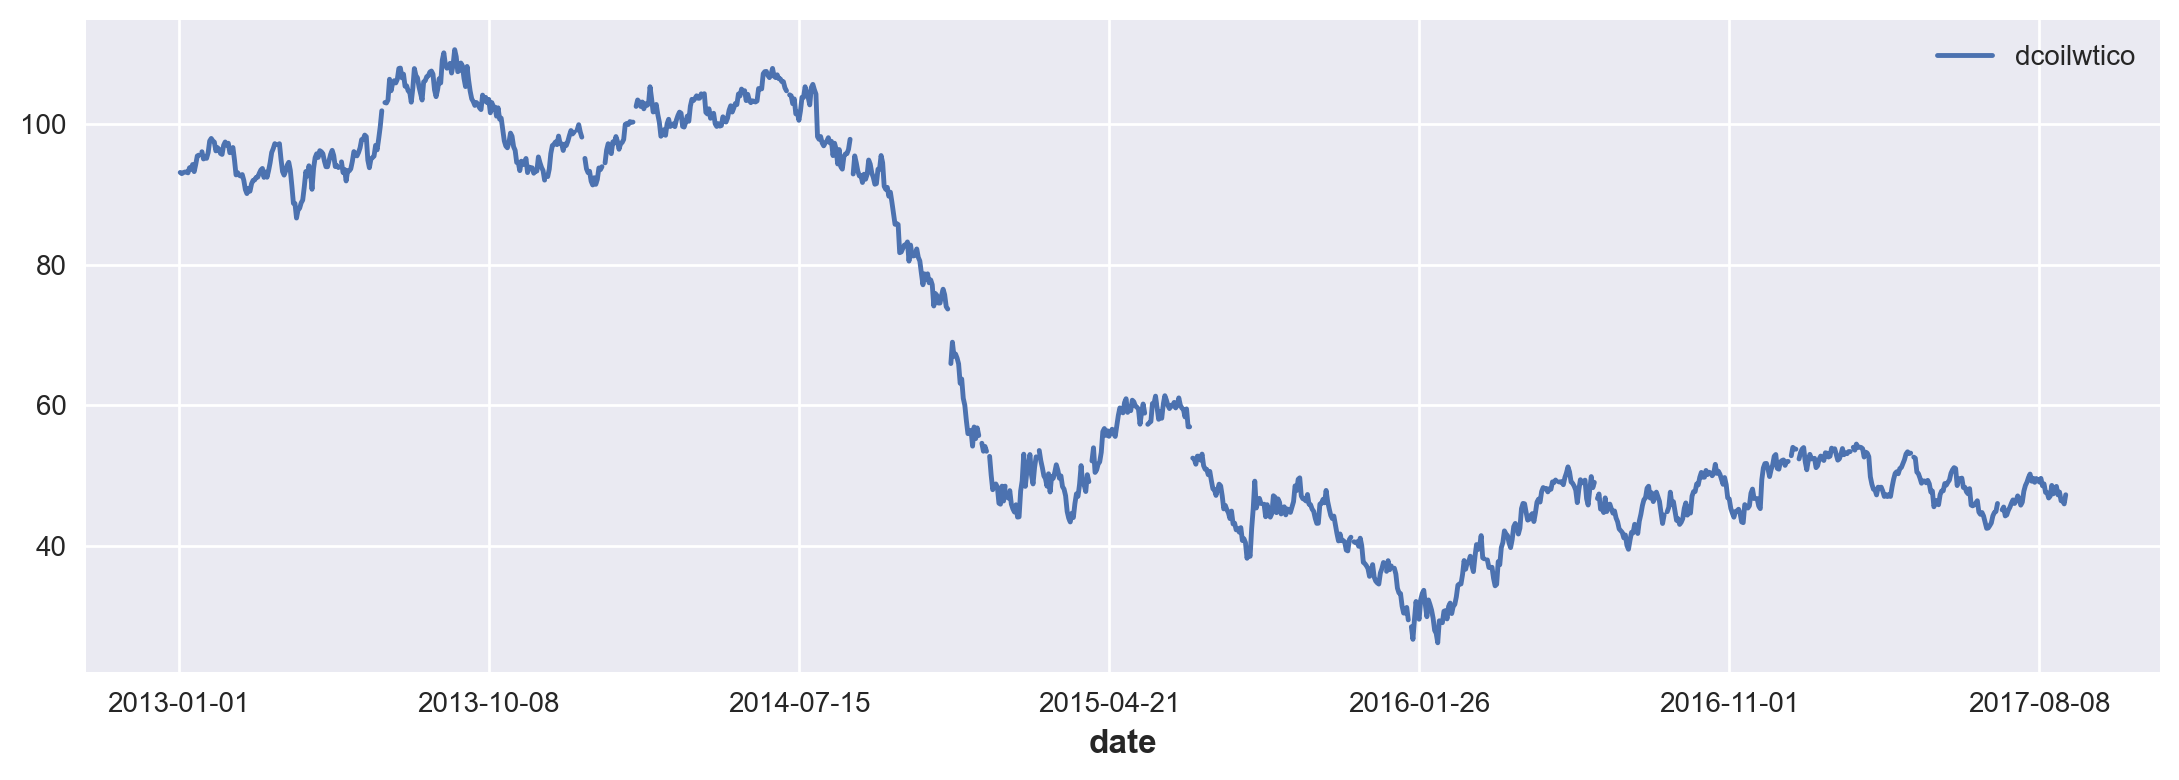

In [10]:
# Visualize the trend of oil prices

oil_df = oil.set_index('date')
oil_df.plot()

In [11]:
# Evaluating the first five rows of the stores dataset

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [12]:
# Evaluating the first five rows of the transactions dataset

transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [13]:
# Evaluating the first five rows of the train dataset

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [14]:
# Evaluating the first five rows of the test dataset

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [15]:
# Evaluating the first five rows of the sample_submission dataset

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [16]:
# Create a dictionary of the datasets

data = {'holiday': holiday, 'oil': oil, 'stores': stores, 'transactions': transactions, 'train': train, 'test': test, 'sample_submission': sample_submission}

In [17]:
# Check the datatypes and presence of missing values in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold

for df, dataset in data.items():
    print(f'\033[1mFor {df} dataset\033[0m:')
    dataset.info()
    print('_'*45)
    print('\n')

For holiday dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
_____________________________________________


For oil dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
_____________________________________________


For stores dataset:
<class 'pandas.core.frame.DataFrame'>
Ran

In [18]:
# Check the shape, and the presence of missing values and duplicates in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold

for df, dataset in data.items():
    print(f'\033[1mFor {df} dataset\033[0m')
    print(f'Shape: {dataset.shape}')
    print(f'Missing values = {dataset.isna().sum().sum()}')
    print(f'Duplicates = {dataset.duplicated().sum()}')
    print('_'*30)
    print('\n')

For holiday dataset
Shape: (350, 6)
Missing values = 0
Duplicates = 0
______________________________


For oil dataset
Shape: (1218, 2)
Missing values = 43
Duplicates = 0
______________________________


For stores dataset
Shape: (54, 5)
Missing values = 0
Duplicates = 0
______________________________


For transactions dataset
Shape: (83488, 3)
Missing values = 0
Duplicates = 0
______________________________


For train dataset
Shape: (3000888, 6)
Missing values = 0
Duplicates = 0
______________________________


For test dataset
Shape: (28512, 5)
Missing values = 0
Duplicates = 0
______________________________


For sample_submission dataset
Shape: (28512, 2)
Missing values = 0
Duplicates = 0
______________________________




# Problems Identified

The datasets are seperate, and need to be merged together for better analysis.

The oil dataset has 43 missing values on the 'dcoilwtico' column which should be filled.

Each of the 'date' columns have an object datatype instead of a datetime datatype.

# Data Preparation

The problems identified with the datasets will be handled to prepare the data for analysis and modelling. First, The datatype of the columns of the store dataset will be changed to category to save memory after merging.

In [19]:
# Change the datatype of the columns of the store dataset to category to save memory after merging

stores['type'] = stores['type'].astype('category')
stores['city'] = stores['city'].astype('category')
stores['state'] = stores['state'].astype('category')
stores['cluster'] = stores['cluster'].astype('category')

# Confirm that there are no missing values on the store dataset after changing the column datatypes
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

### Merge the datasets based on common columns

In [20]:
# Merge transactions dataset to train on 'date' and 'store_nbr' columns
df1 = pd.merge(train, transactions, on=['date', 'store_nbr'], how='left')

# Merge holiday dataset to df1 on 'date' column
df2 = pd.merge(df1, holiday, on='date', how='left')

# Merge oil dataset to df2 on 'date' column
df3 = pd.merge(df2, oil, on='date', how='left')
df3

# Merge store dataset to df3 on 'store_nbr' column
df4 = pd.merge(df3, stores, on='store_nbr', how='left')

df4.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


In [21]:
# Check for duplicates after merging the datasets

df4.duplicated().sum()

0

In [22]:
# Create a copy of the dataset

df = df4.copy()

In [23]:
# Evaluating 'type_x' column on df4

df['type_x'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

In [24]:
# Evaluating 'type_y' column on df4

df['type_y'].unique()

['D', 'C', 'B', 'E', 'A']
Categories (5, object): ['A', 'B', 'C', 'D', 'E']

As can be seen in the merged dataset, the column named type_x is the type column of the holiday dataset, the column named dcoilwtico represents the oil price in the oil dataset, while the column named type_y is the type column of the store dataset. These columns will be renamed for easy identification.

In [25]:
# Rename 'type_x', 'dcoilwtico' and type_y' to 'holiday_type', 'oil_price' and 'store_type' respectively

df = df.rename(columns={'type_x': 'holiday_type', 'dcoilwtico': 'oil_price', 'type_y': 'store_type'})
df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


### Filling missing values

In [26]:
# Check for missing values after merging the datasets

df.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

The missing values in the transactions column will be filled with 0 because it represents the absence of transactions on those days.

In [27]:
# Fill the missing values in the transactions column with 0

df['transactions'].fillna(0, inplace=True)
df.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions          0
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

For holiday_type, locale, locale_name, description and transferred columns, there are equal number of missing values. This is because these columns are from the holiday dataset, and they represent the days where there were no holidays. These empty cells will be filled with 'No holiday' for easy identification.

In [28]:
# Fill the missing values in type_x, locale, locale_name, description and transferred columns with 'No holiday'
columns_to_fill = ['holiday_type', 'locale', 'locale_name', 'description', 'transferred']
for column in columns_to_fill:
        df[column].fillna('No holiday', inplace=True)

# Confirm that there are no more missing values in these columns
df.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions         0
holiday_type         0
locale               0
locale_name          0
description          0
transferred          0
oil_price       955152
city                 0
state                0
store_type           0
cluster              0
dtype: int64

<Axes: >

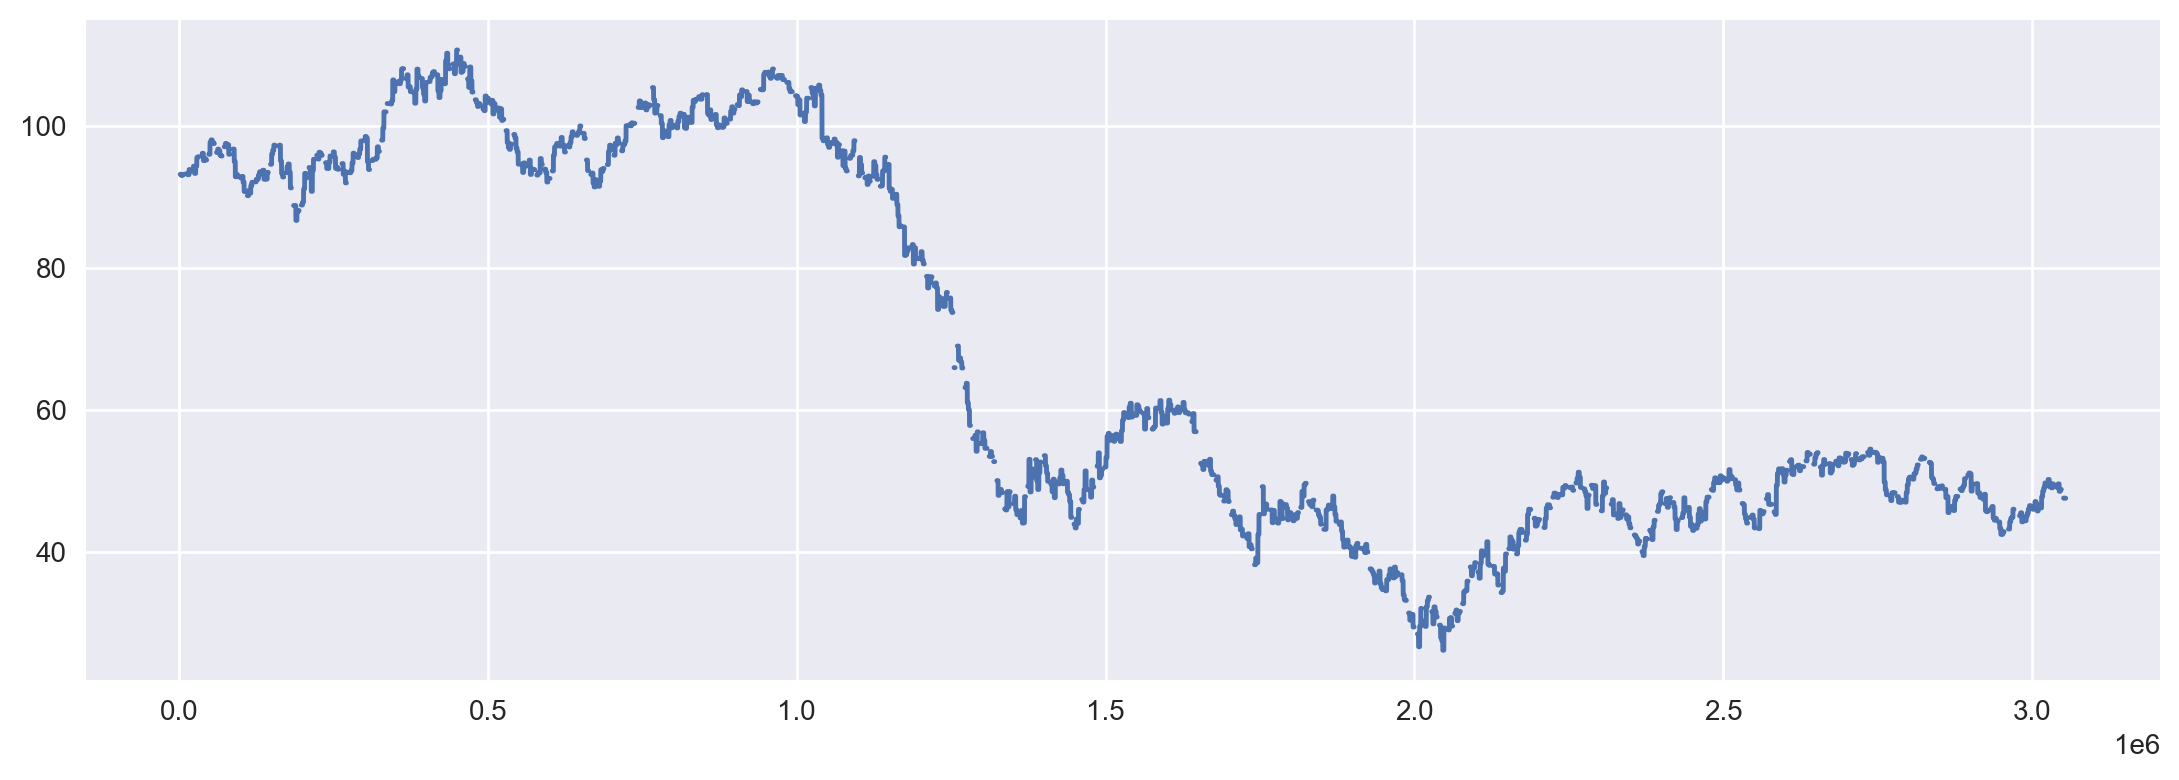

In [29]:
# Visualize the trend of oil prices before filling the missing values

df['oil_price'].plot()

In [30]:
# Fill the missing values in the oil prices using backward fill to ensure continuity in the trend
df['oil_price'].fillna(method='bfill', inplace=True)

# Confirm that there are no more missing values
df.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
oil_price       0
city            0
state           0
store_type      0
cluster         0
dtype: int64

<Axes: >

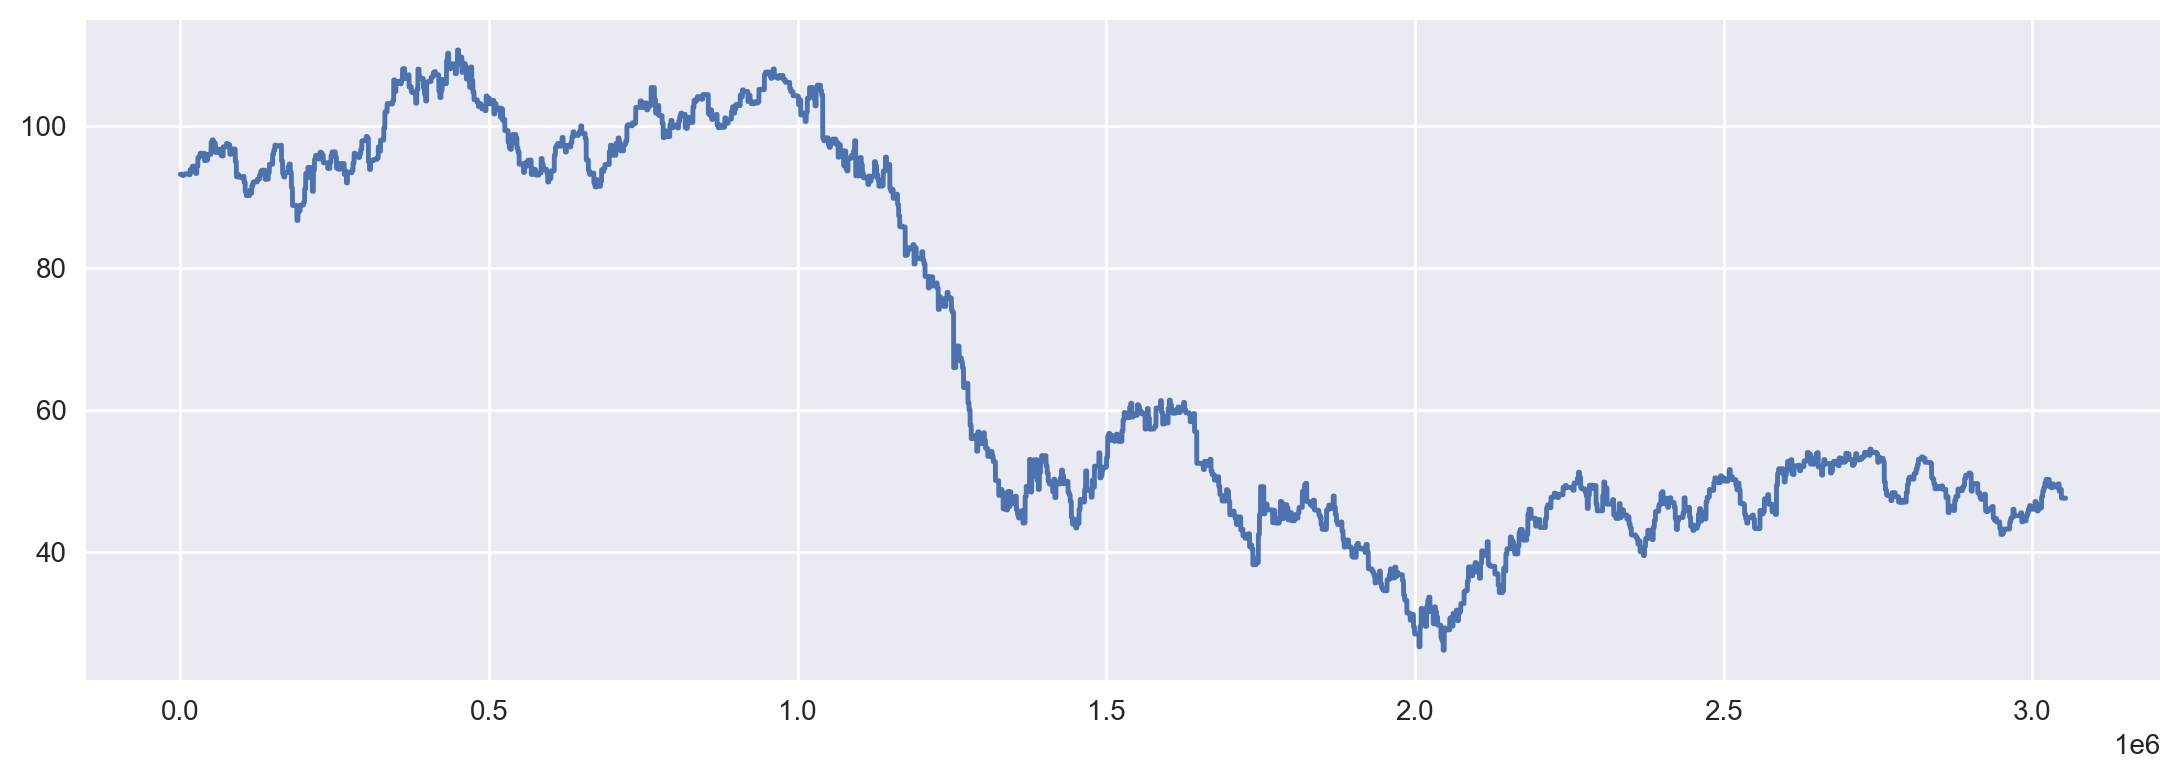

In [31]:
# Visualize the trend of oil prices after filling the missing values

df['oil_price'].plot()

### Change the datatype of the 'date' column from object to datetime

In [32]:
# Change the datatype of the date column to datetime
df['date'] = pd.to_datetime(df['date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   transactions  float64       
 7   holiday_type  object        
 8   locale        object        
 9   locale_name   object        
 10  description   object        
 11  transferred   object        
 12  oil_price     float64       
 13  city          category      
 14  state         category      
 15  store_type    category      
 16  cluster       category      
dtypes: category(4), datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 314.6+ MB


In [33]:
# Create new features from the 'date' column using pandas' powerful time-based indexing

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['dayofmonth'] = df.date.dt.day
df['dayofweek'] = df.date.dt.dayofweek
df['dayname'] = df.date.dt.strftime('%A')

df.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,...,oil_price,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday


In [34]:
# Set the 'date' column as index

df = df.set_index('date')
df.head()

,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,...,oil_price,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
2013-01-01,1,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
2013-01-01,2,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
2013-01-01,3,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
2013-01-01,4,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday


In [35]:
# Rename df to train_merged

train_merged = df.copy()

In [36]:
# Display random sample of 8 rows

train_merged.sample(8, random_state = 42)

,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,...,oil_price,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
date,,,,,,,,,,,,,,,,,,,,,
2014-01-07,659843,23,DAIRY,471.000,0,1135.0,No holiday,No holiday,No holiday,No holiday,...,93.309998,Ambato,Tungurahua,D,9,2014,1,7,1,Tuesday
2014-12-05,1250966,1,BEAUTY,1.000,0,2028.0,Additional,Local,Quito,Fundacion de Quito-1,...,65.889999,Quito,Pichincha,D,13,2014,12,5,4,Friday
2014-07-06,981404,45,HOME APPLIANCES,0.000,0,4626.0,No holiday,No holiday,No holiday,No holiday,...,104.190002,Quito,Pichincha,A,11,2014,7,6,6,Sunday
2014-05-02,864686,20,LAWN AND GARDEN,0.000,0,0.0,No holiday,No holiday,No holiday,No holiday,...,100.089996,Quito,Pichincha,B,6,2014,5,2,4,Friday
2014-02-25,747235,25,HOME AND KITCHEN II,0.000,0,705.0,No holiday,No holiday,No holiday,No holiday,...,102.199997,Salinas,Santa Elena,D,1,2014,2,25,1,Tuesday
2014-01-26,694647,49,PRODUCE,7866.909,0,2744.0,No holiday,No holiday,No holiday,No holiday,...,95.820000,Quito,Pichincha,A,11,2014,1,26,6,Sunday
2014-11-23,1231012,49,GROCERY II,107.000,0,3096.0,No holiday,No holiday,No holiday,No holiday,...,75.739998,Quito,Pichincha,A,11,2014,11,23,6,Sunday
2013-08-24,419196,20,PRODUCE,0.000,0,0.0,Holiday,Local,Ambato,Fundacion de Ambato,...,105.879997,Quito,Pichincha,B,6,2013,8,24,5,Saturday


Text(0.5, 0, 'Year')

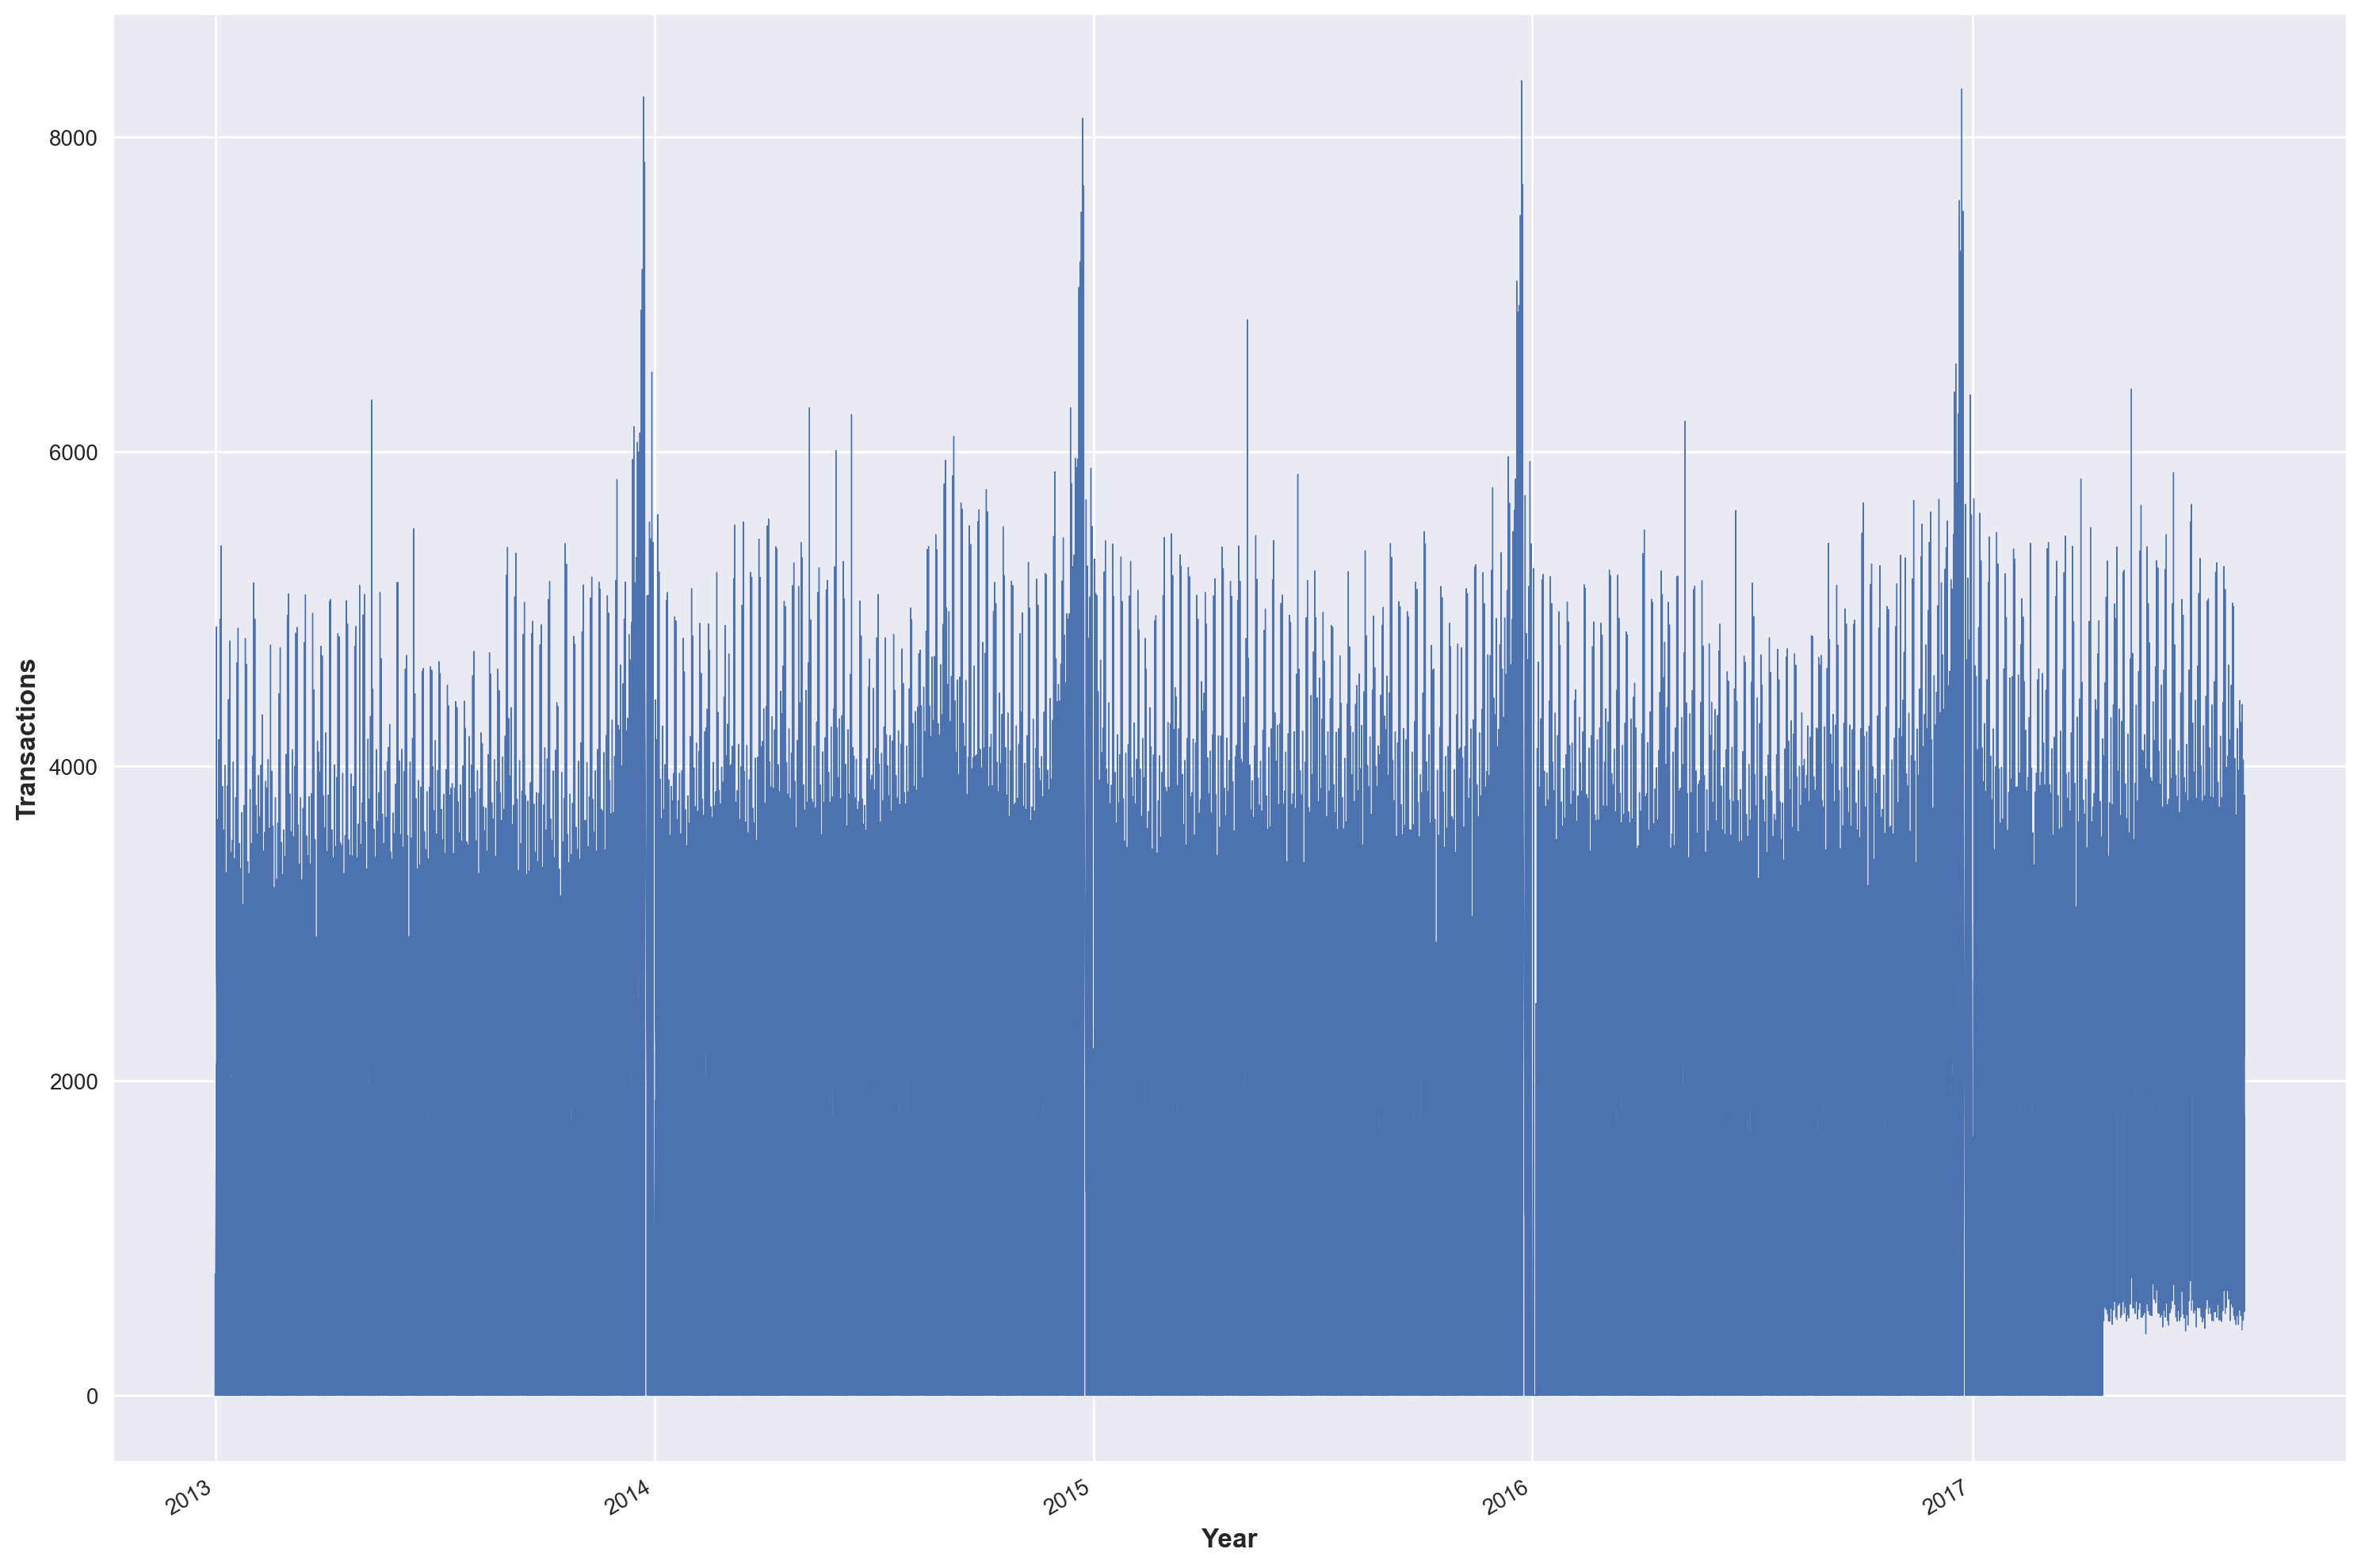

In [37]:
# Visualize the 'transactions' column

plt.figure(figsize=(15,10))
ax = train_merged['transactions'].plot(linewidth=0.5)
ax.set_ylabel('Transactions')
ax.set_xlabel('Year')

The plot above reveals that transactions are always highest at the end of each year. This reveals seasonality in the dataset.

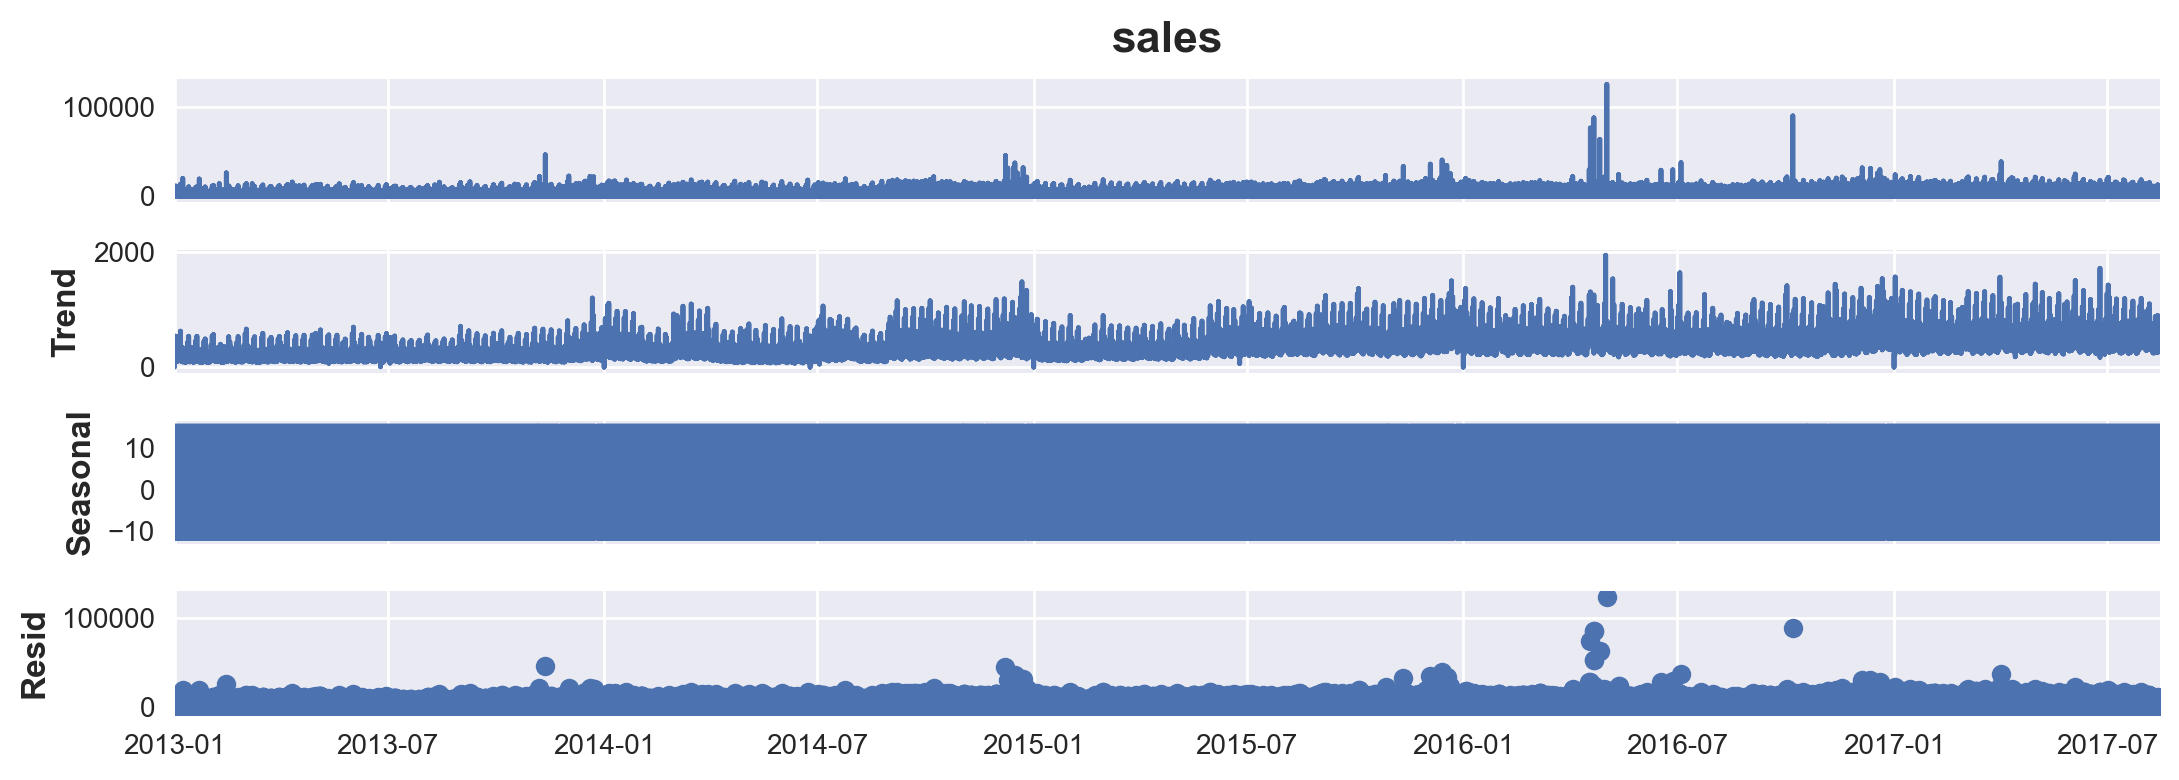

In [38]:
# Perform seasonal decomposition

result = seasonal_decompose(train_merged['sales'], model='additive', period=365)
result.plot()
plt.show()

In [39]:
# series = train_merged.loc[:, 'transactions'].values
# series

In [40]:
# # Check for stationarity using adfuller

# result = adfuller(series, autolag='AIC')

# print(f'ADF Statistics: {result[0]}')
# print(f'p-value: {result[1]}')
# print(f'Critical Values: {result[4]}')

# if result[1] > 0.05 :
#     print('Series is not stationary')
# else:
#     print('Series is stationary')

In [41]:
# # Create an autocorrelation plot

# pd.plotting.autocorrelation_plot(train_merged['2013':'2017']['transactions'])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

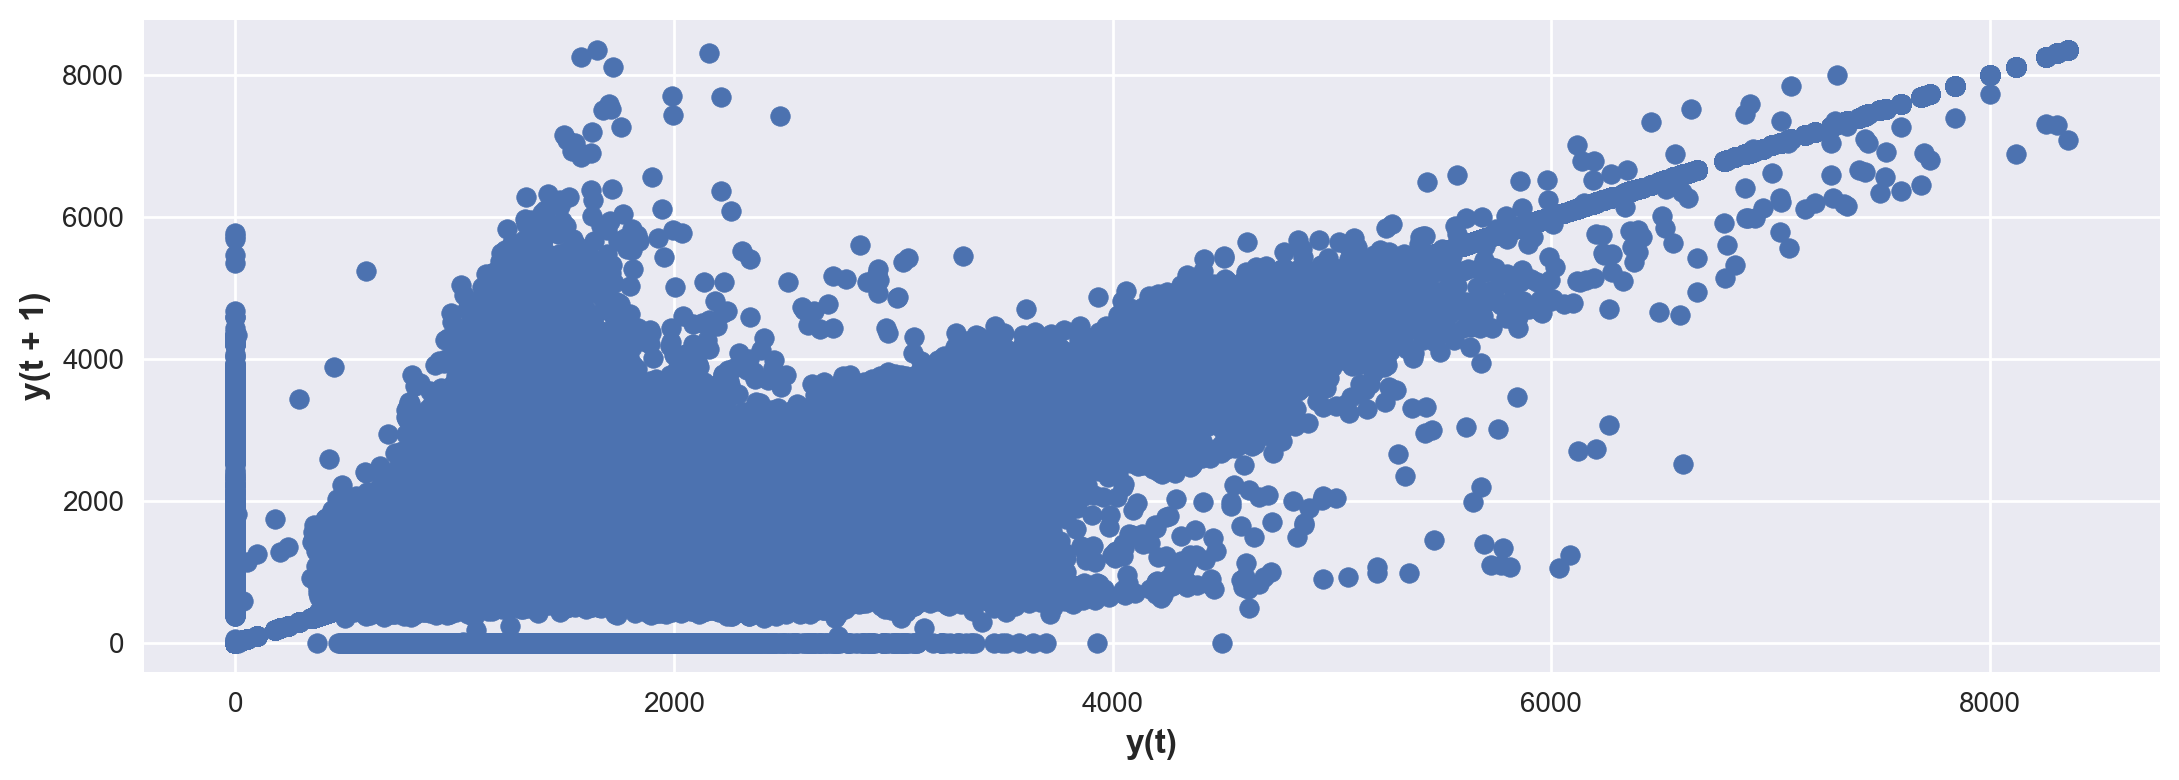

In [42]:
# Create a lag plot

pd.plotting.lag_plot(train_merged['transactions'], lag=1)

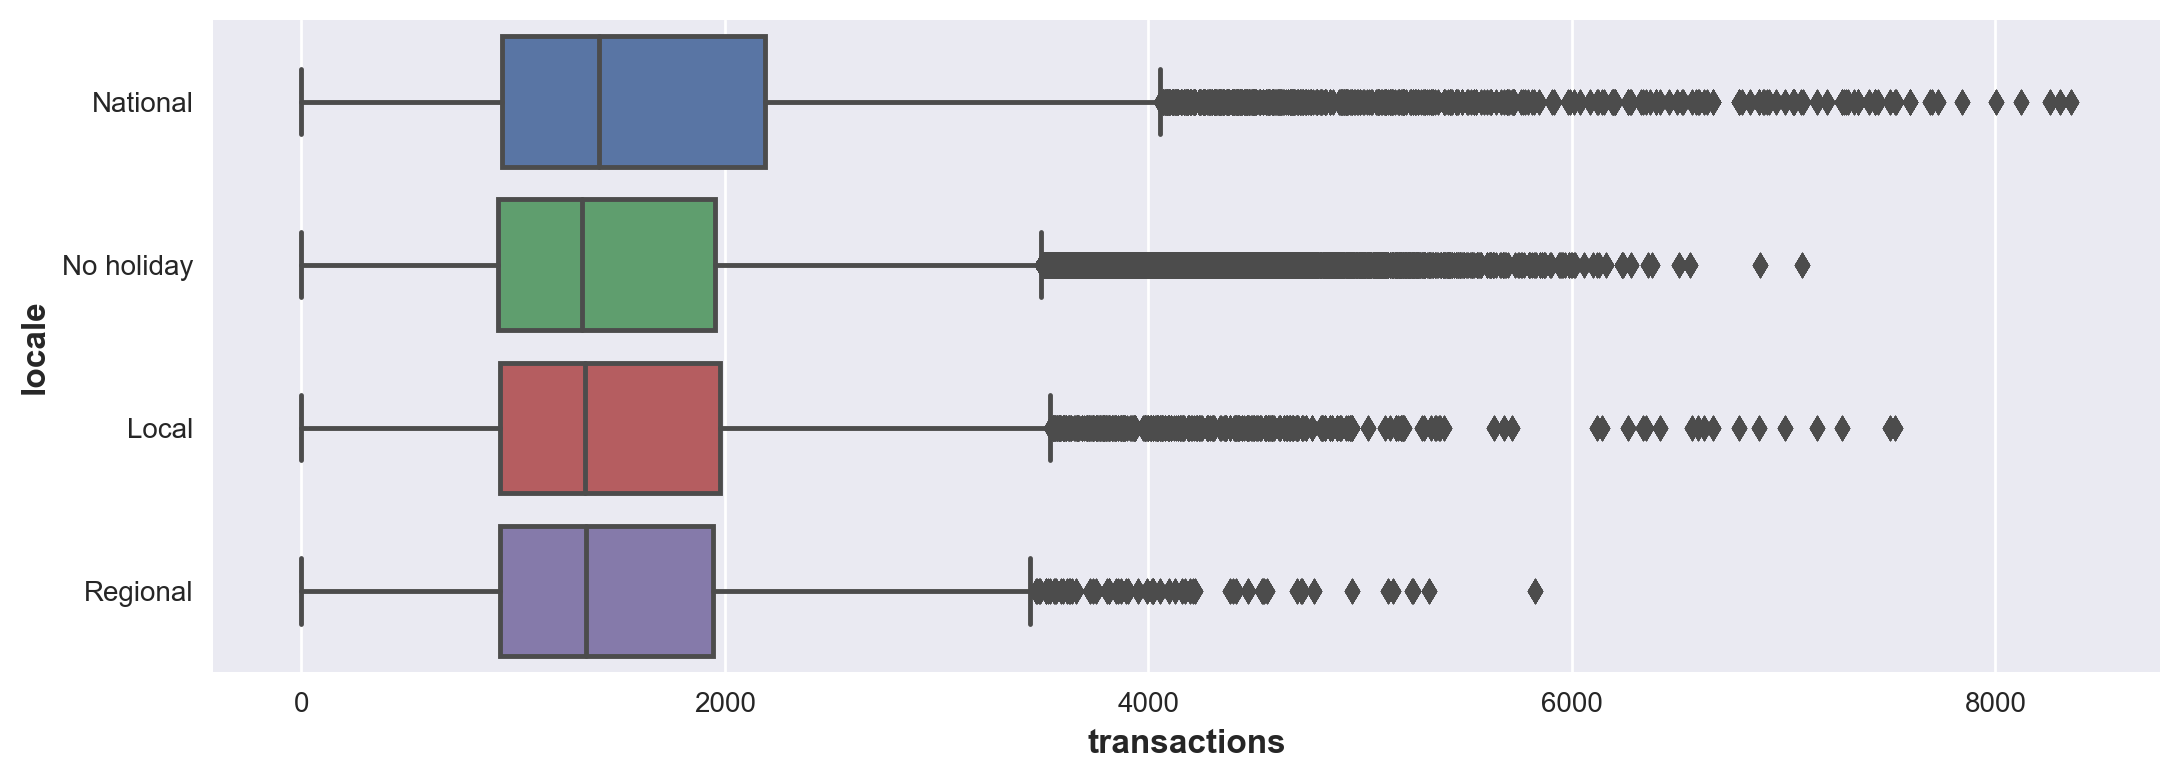

In [43]:
# Create a boxplot of the 'transactions' column grouped by 'locale'
sns.boxplot(x='transactions', y='locale', data=train_merged)

# Show the plot
plt.show()

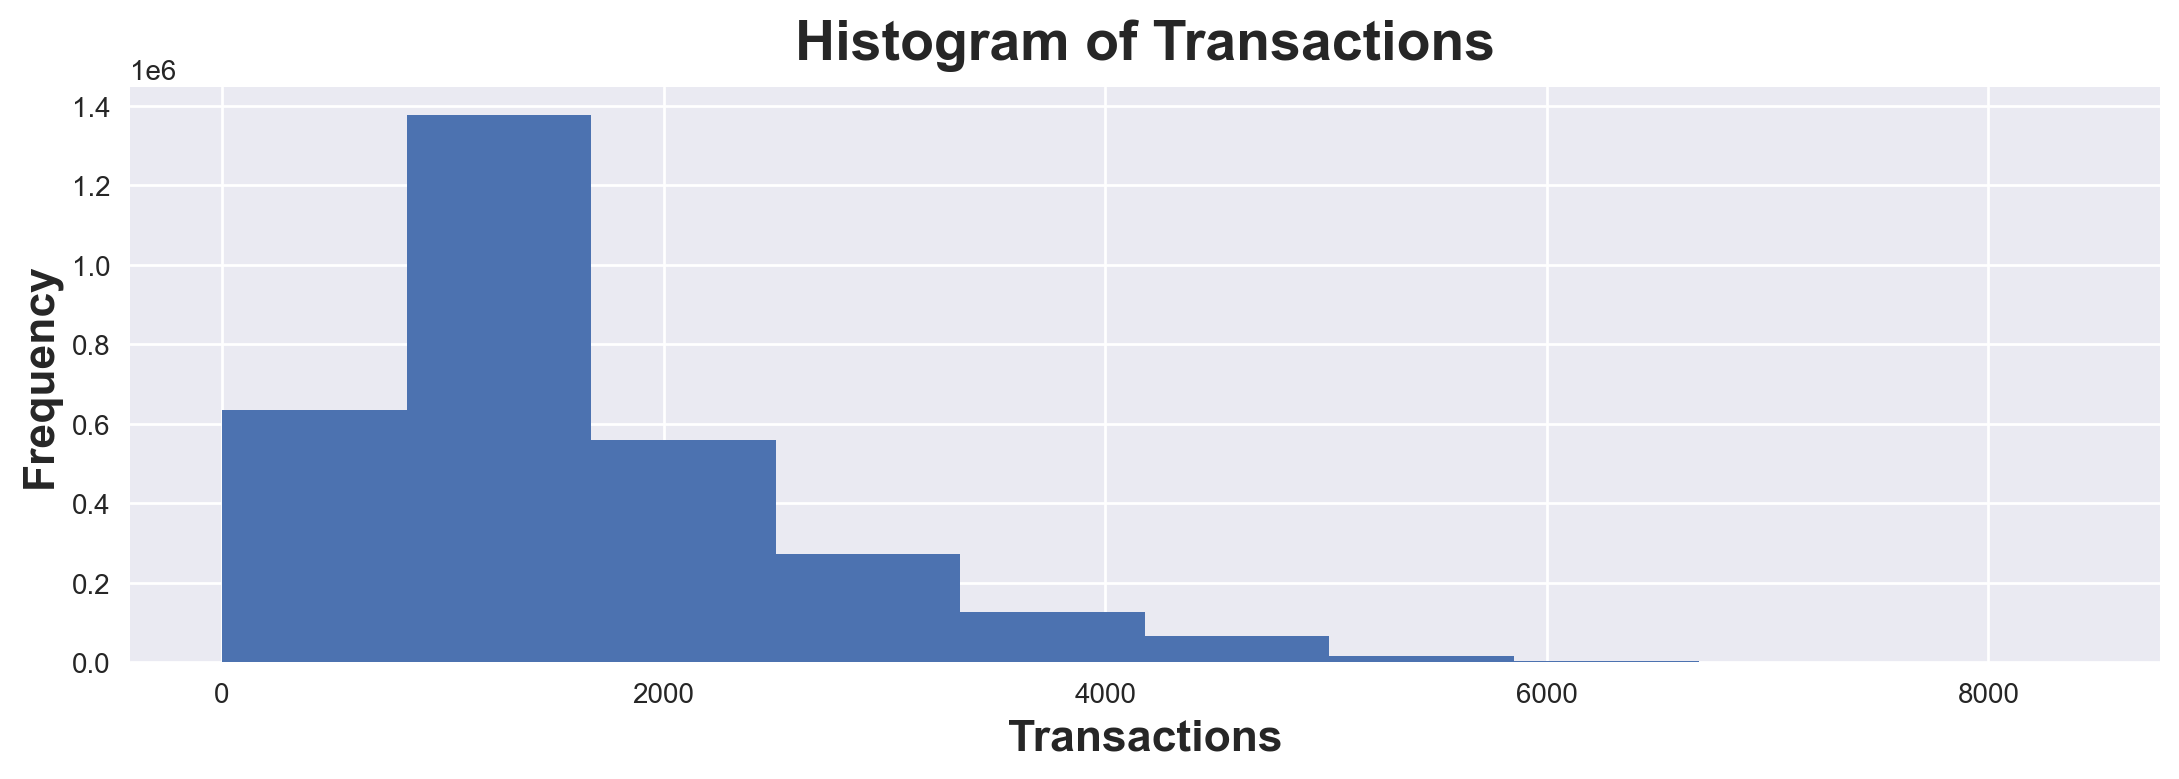

In [44]:
# Create a histogram of the 'transactions' column
train_merged.transactions.hist()

# Add labels to the x-axis, y-axis, and title
plt.xlabel('Transactions', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Transactions', fontsize=20)

# Show the plot
plt.show()

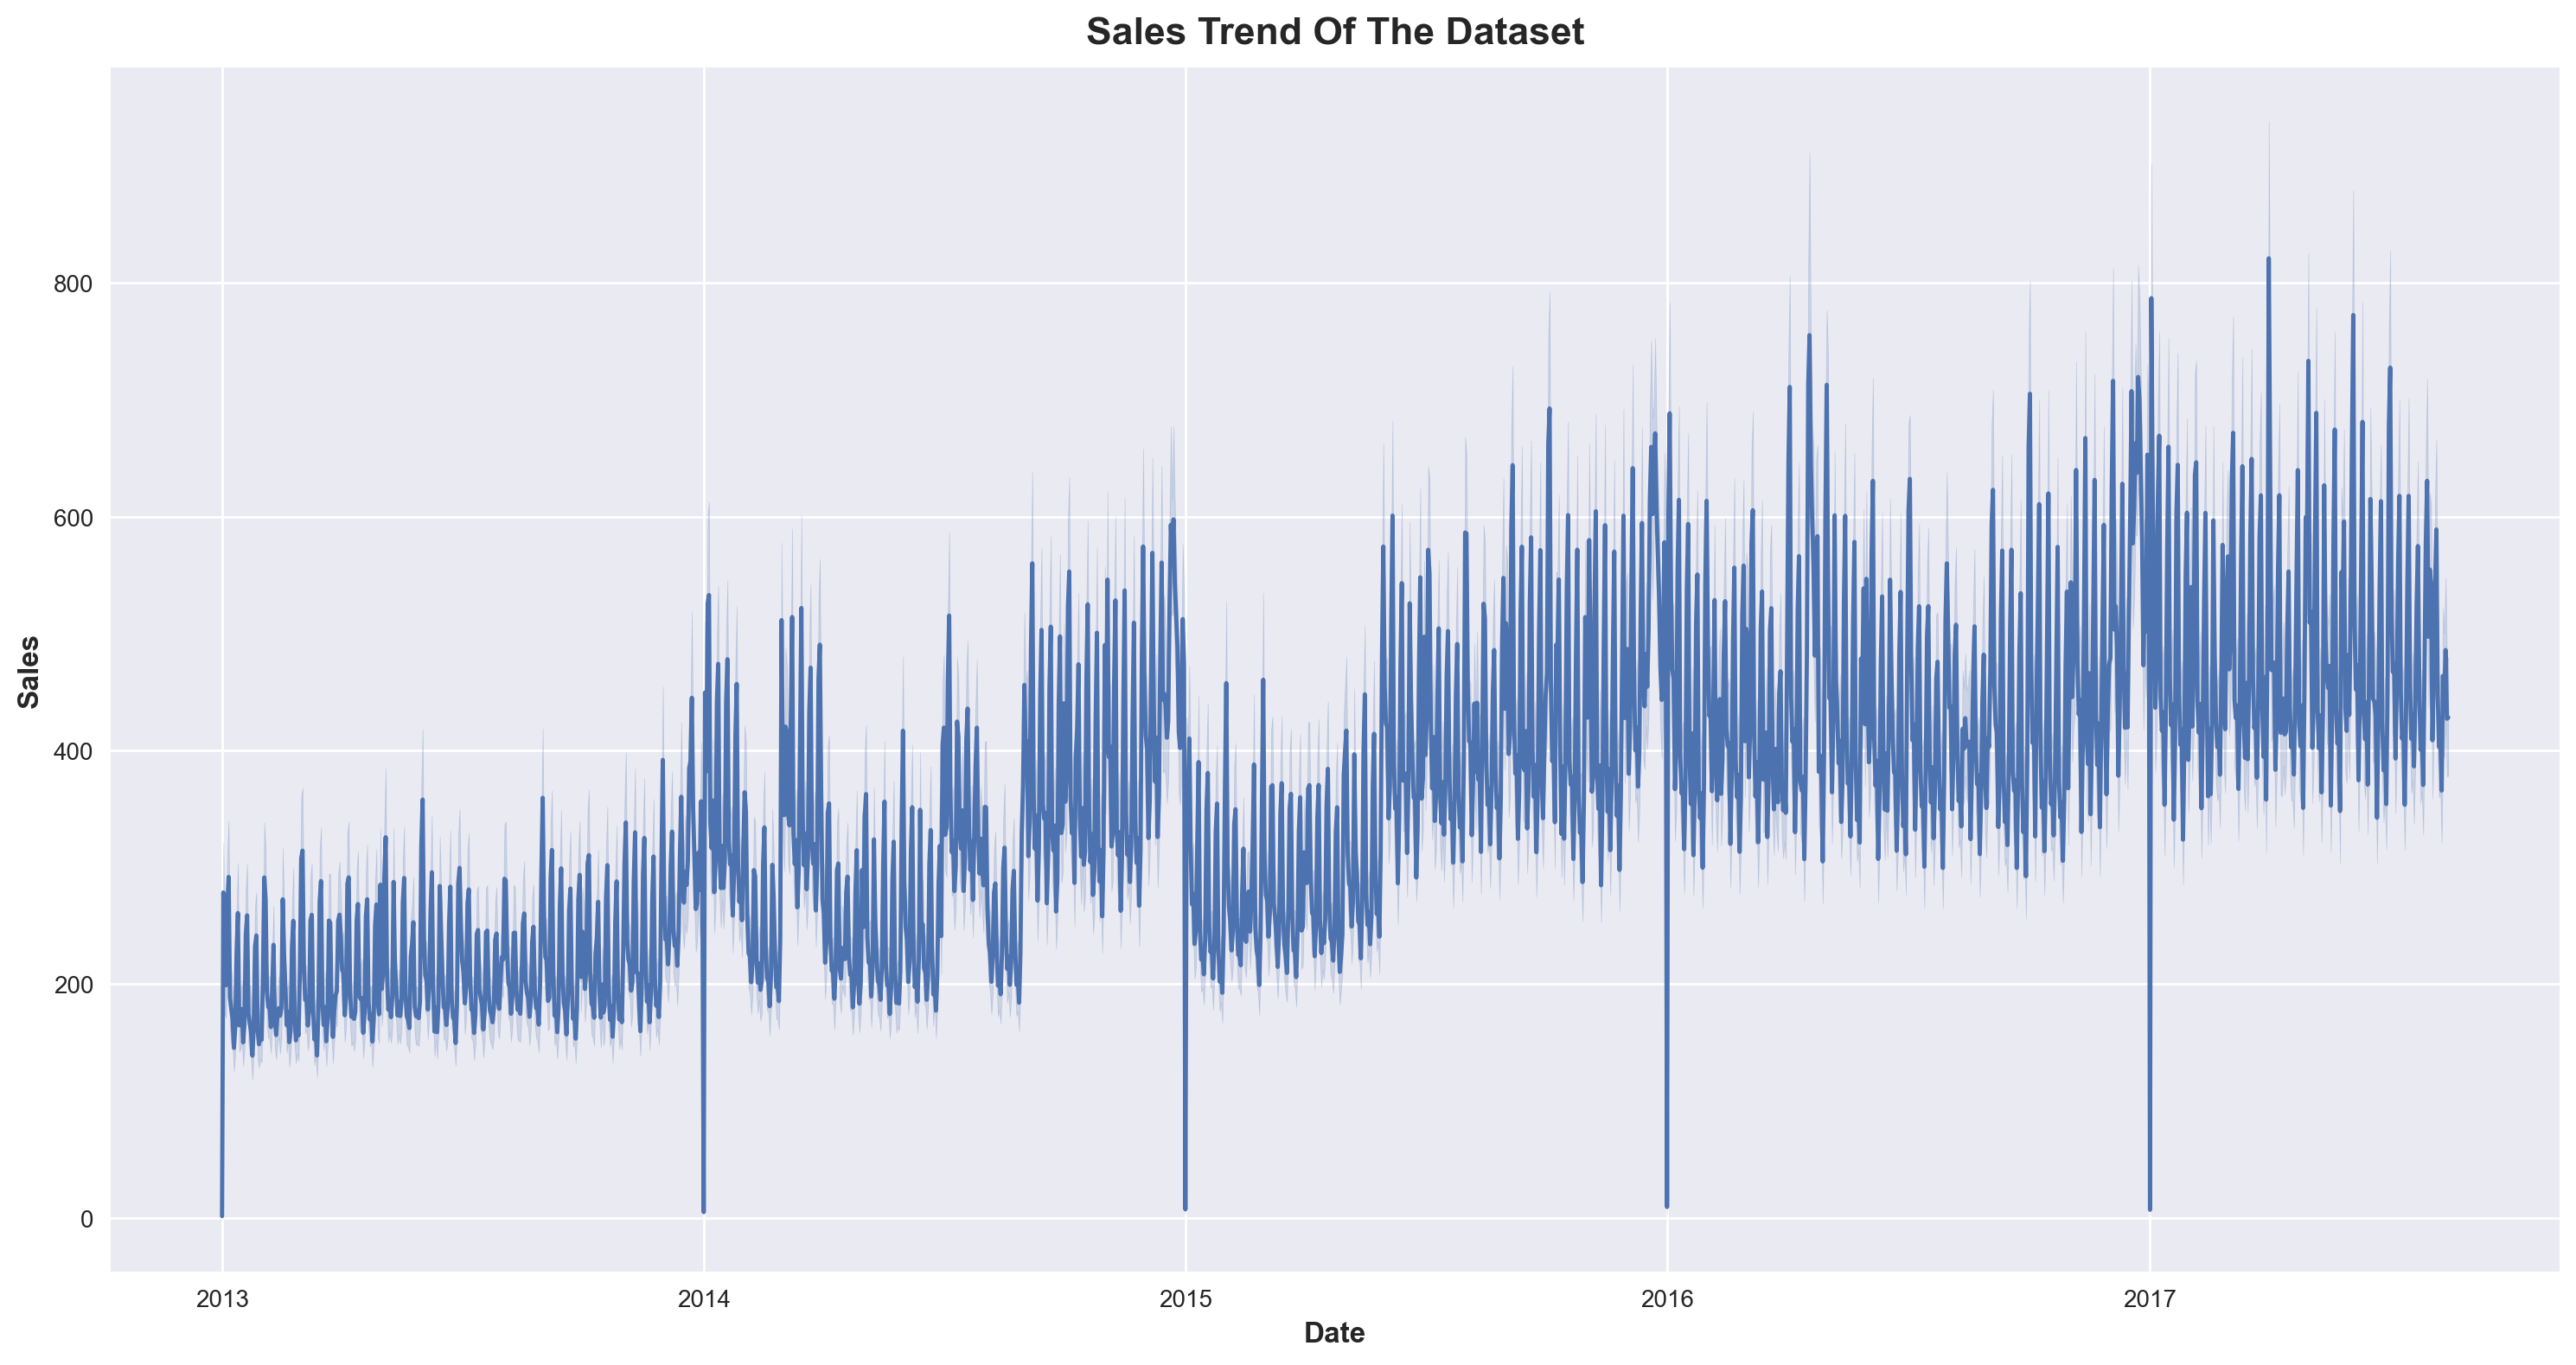

In [45]:
# Visualize the sales trend of the dataset

plt.figure(figsize=(15,8))
sns.lineplot(x='date', y='sales', data=train_merged)
plt.title('Sales Trend Of The Dataset')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [46]:
# Generate summary statistics for numerical columns in train_data DataFrame

train_merged.describe()

,id,store_nbr,sales,onpromotion,transactions,oil_price,year,month,dayofmonth,dayofweek
count,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06
mean,1.504277e+06,2.750000e+01,3.590209e+02,2.617480e+00,1.558656e+03,6.778930e+01,2.014842e+03,6.222870e+00,1.565694e+01,3.008168e+00
std,8.662610e+05,1.558579e+01,1.107286e+03,1.225494e+01,1.036468e+03,2.570258e+01,1.345607e+00,3.374251e+00,8.801398e+00,2.001442e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,7.546768e+05,1.400000e+01,0.000000e+00,0.000000e+00,9.310000e+02,4.628000e+01,2.014000e+03,3.000000e+00,8.000000e+00,1.000000e+00
50%,1.507572e+06,2.750000e+01,1.100000e+01,0.000000e+00,1.332000e+03,5.319000e+01,2.015000e+03,6.000000e+00,1.600000e+01,3.000000e+00
75%,2.255120e+06,4.100000e+01,1.960110e+02,0.000000e+00,1.980000e+03,9.580000e+01,2.016000e+03,9.000000e+00,2.300000e+01,5.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,8.359000e+03,1.106200e+02,2.017000e+03,1.200000e+01,3.100000e+01,6.000000e+00


<Axes: >

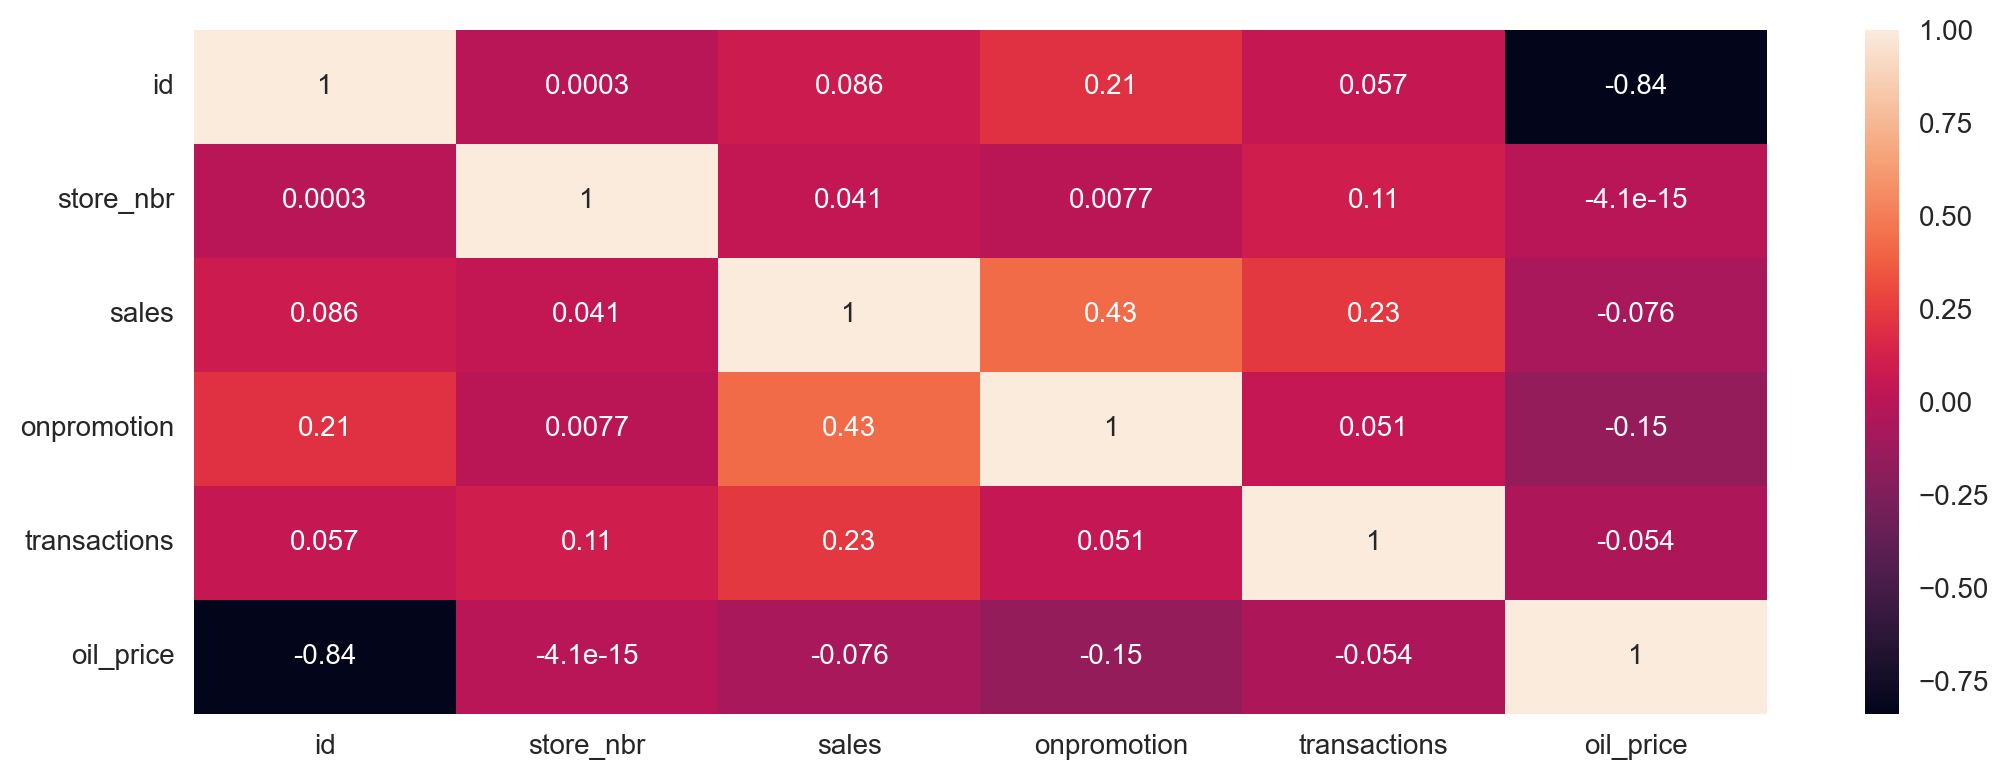

In [47]:
# Create a DataFrame of train_data with numerical columns only
train_merged_num = train_merged.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix of the numerical columns
corr_matrix = train_merged_num.corr()

# Visualizing the correlation matrix with a heatmap
sns.heatmap(corr_matrix, annot=True)

# Save the chart as an image file
# plt.savefig('Correlation of the numerical columns of the train dataset.png')

# Hypothesis Testing

# Answering Analytical Questions

### Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

8. What is the total sales made each year by the corporation?

### Question 1

Is the train dataset complete (has all the required dates)?

In [48]:
# Check the range of the date column
dates_range = pd.date_range(start=train_merged.index.min(), end=train_merged.index.max())

# Check for missing dates in the dataset
missing_dates = set(dates_range.date) - set(train_merged.index.unique())

# Create a new dataframe with the dates_missing data
missing_dates_df = pd.DataFrame(missing_dates)
missing_dates_df.head()

,0
0,2015-03-30
1,2014-08-28
2,2016-06-10
3,2016-10-05
4,2013-12-23


The dataset has some missing dates. This means that it is not complete.

### Question 2

Which dates have the lowest and highest sales for each year?

### Question 3

Did the earthquake impact sales?

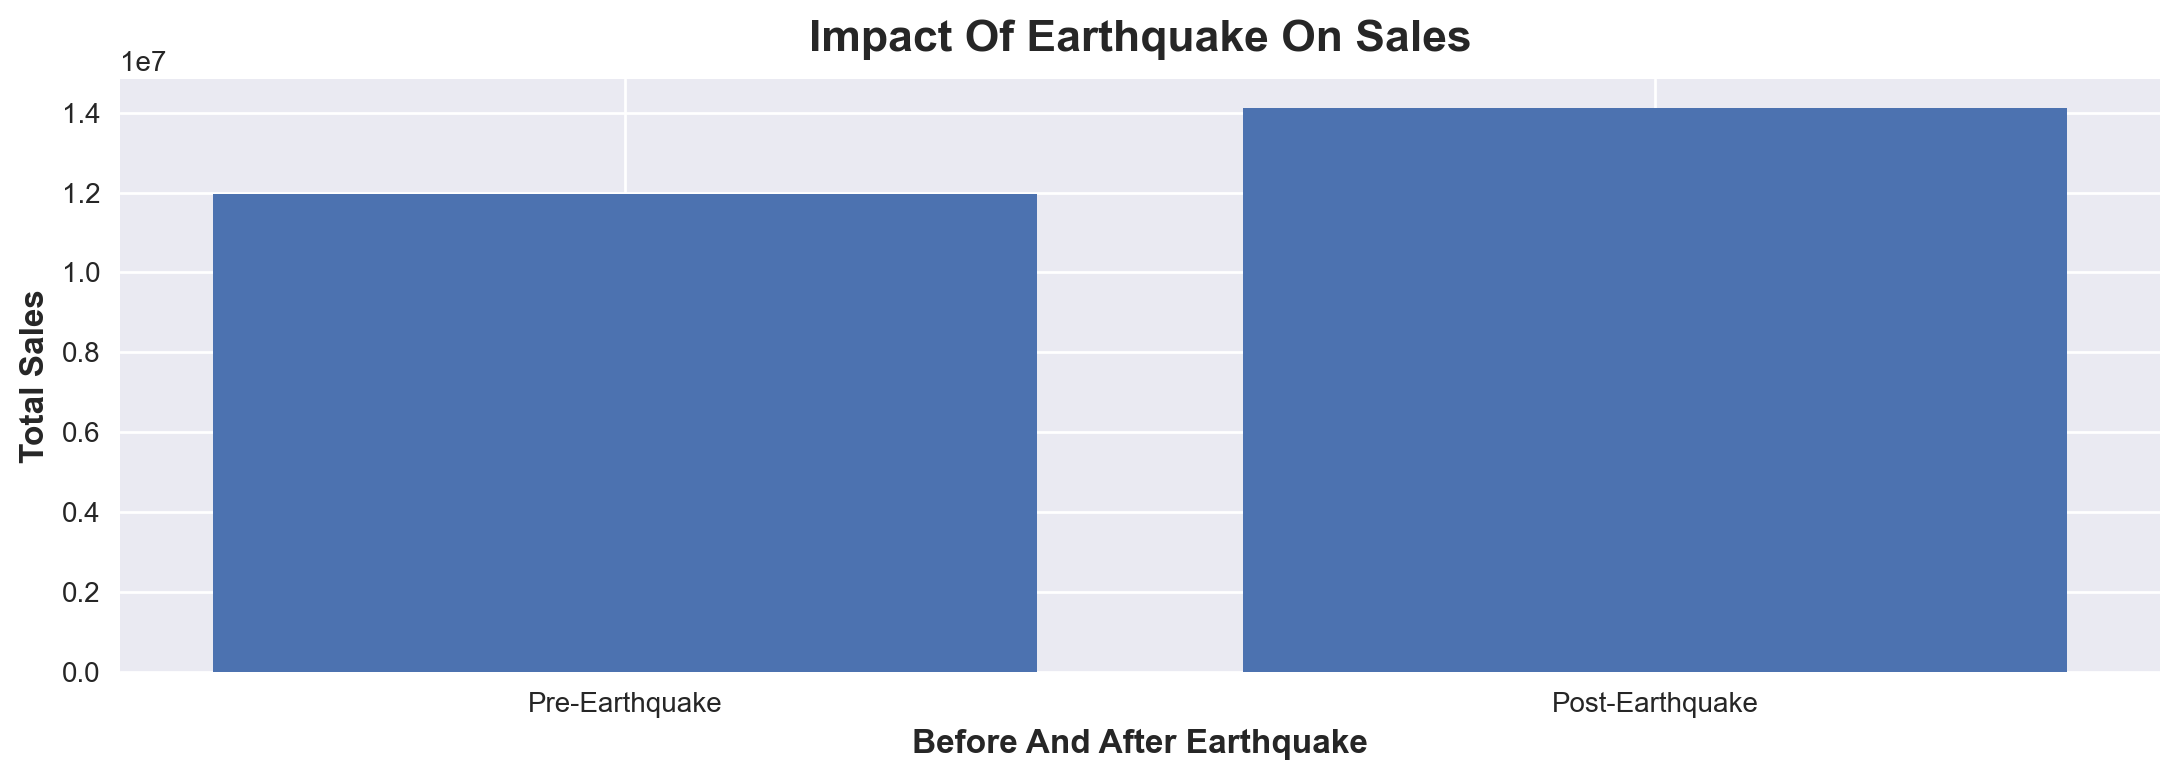

In [49]:
# Define time period before and after the earthquake
pre_earthquake_start_date = '2016-04-01'
pre_earthquake_end_date = '2016-04-15'
post_earthquake_start_date = '2016-04-17'
post_earthquake_end_date = '2016-04-30'

# Filter the sales data before and after the earthquake
pre_earthquake_sales = train_merged[(train_merged.index >= pre_earthquake_start_date) & (train_merged.index <= pre_earthquake_end_date)]
post_earthquake_sales = train_merged[(train_merged.index >= post_earthquake_start_date) & (train_merged.index <= post_earthquake_end_date)]

# Calculate the total sales before and after the earthquake
pre_earthquake_total_sales = pre_earthquake_sales['sales'].sum()
post_earthquake_total_sales = post_earthquake_sales['sales'].sum()

# Visualize the sales data before and after the sales data
labels = ['Pre-Earthquake', 'Post-Earthquake']
total_sales = [pre_earthquake_total_sales, post_earthquake_total_sales]
plt.bar(labels, total_sales)
plt.xlabel('Before And After Earthquake')
plt.ylabel('Total Sales')
plt.title('Impact Of Earthquake On Sales')
plt.show()

The plot above shows that there was a slight increase in sales after the earthquake. This means that the earthquake did not affect the sales.

### Question 4

Are certain groups of stores selling more products? (Cluster, city, state, type)

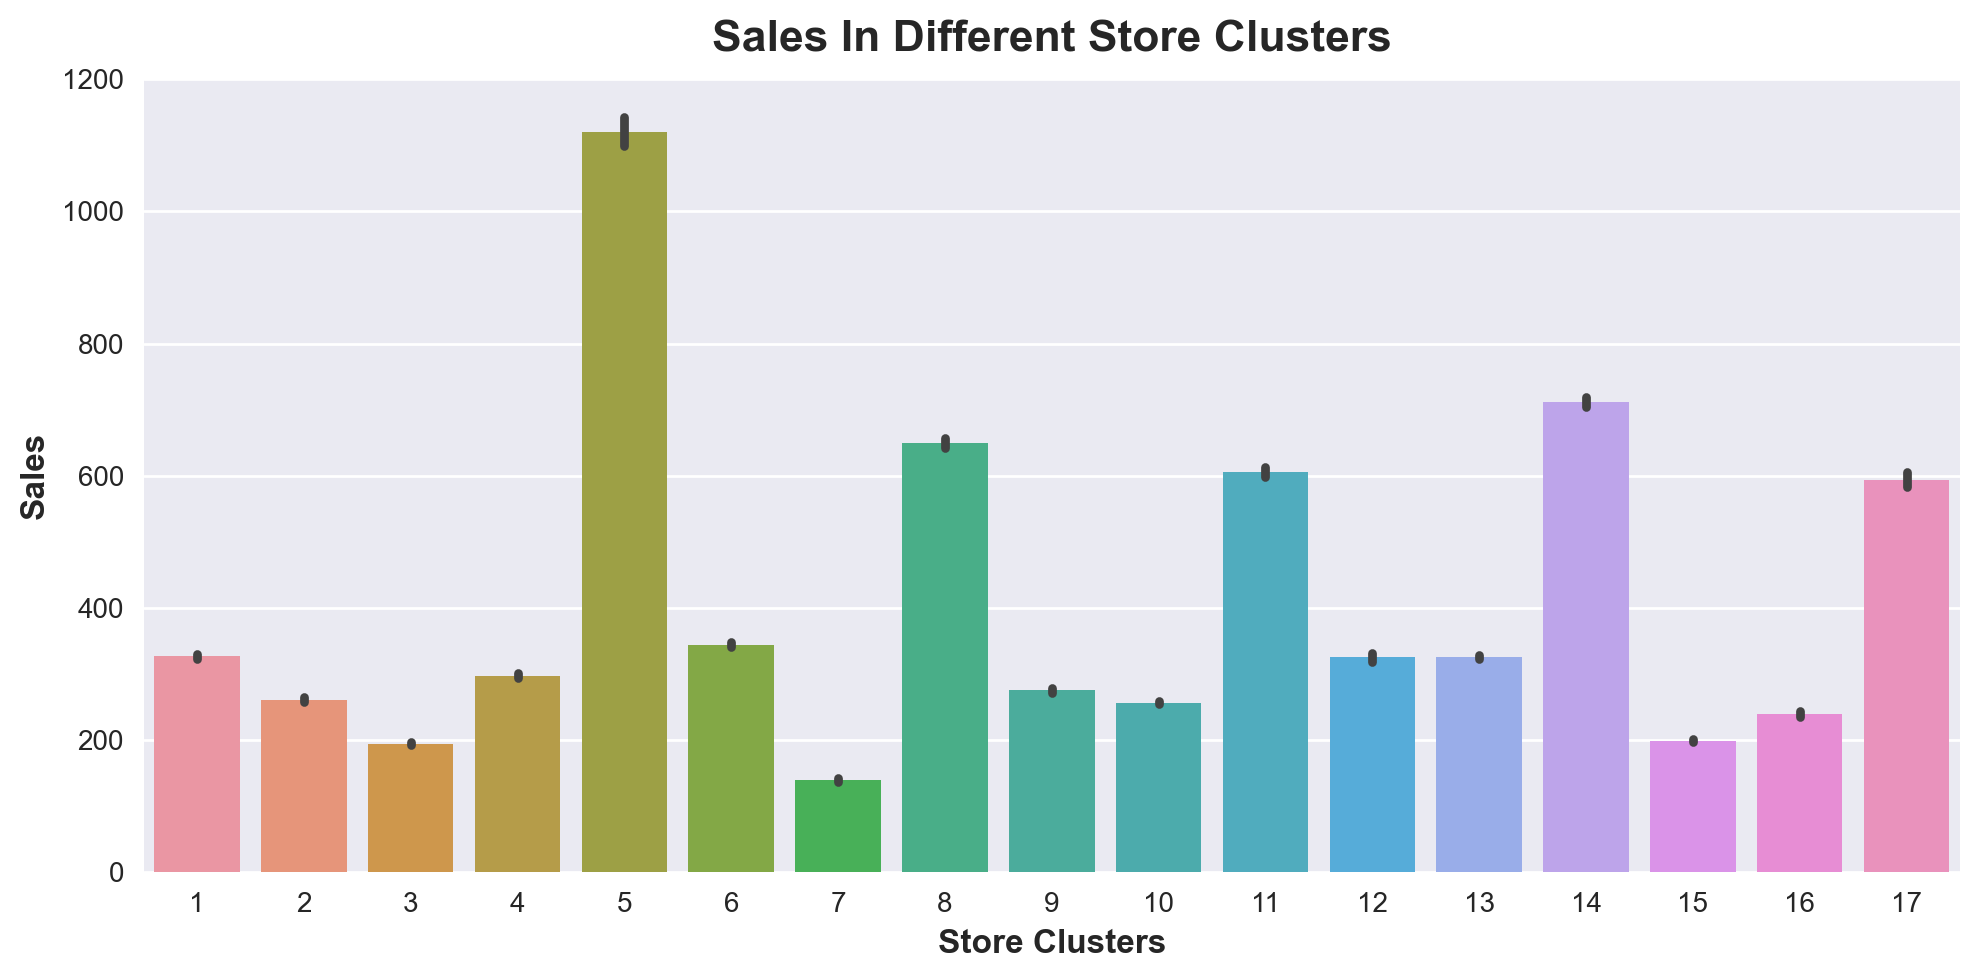

In [50]:
# Compare the sales in the different store clusters

plt.figure(figsize=(10,5))
sns.barplot(x='cluster', y='sales', data=train_merged)
plt.title('Sales In Different Store Clusters')
plt.xlabel('Store Clusters')
plt.ylabel('Sales')
plt.show()

The plot above shows that stores in cluster 5 are making more sales than the stores in other clusters.

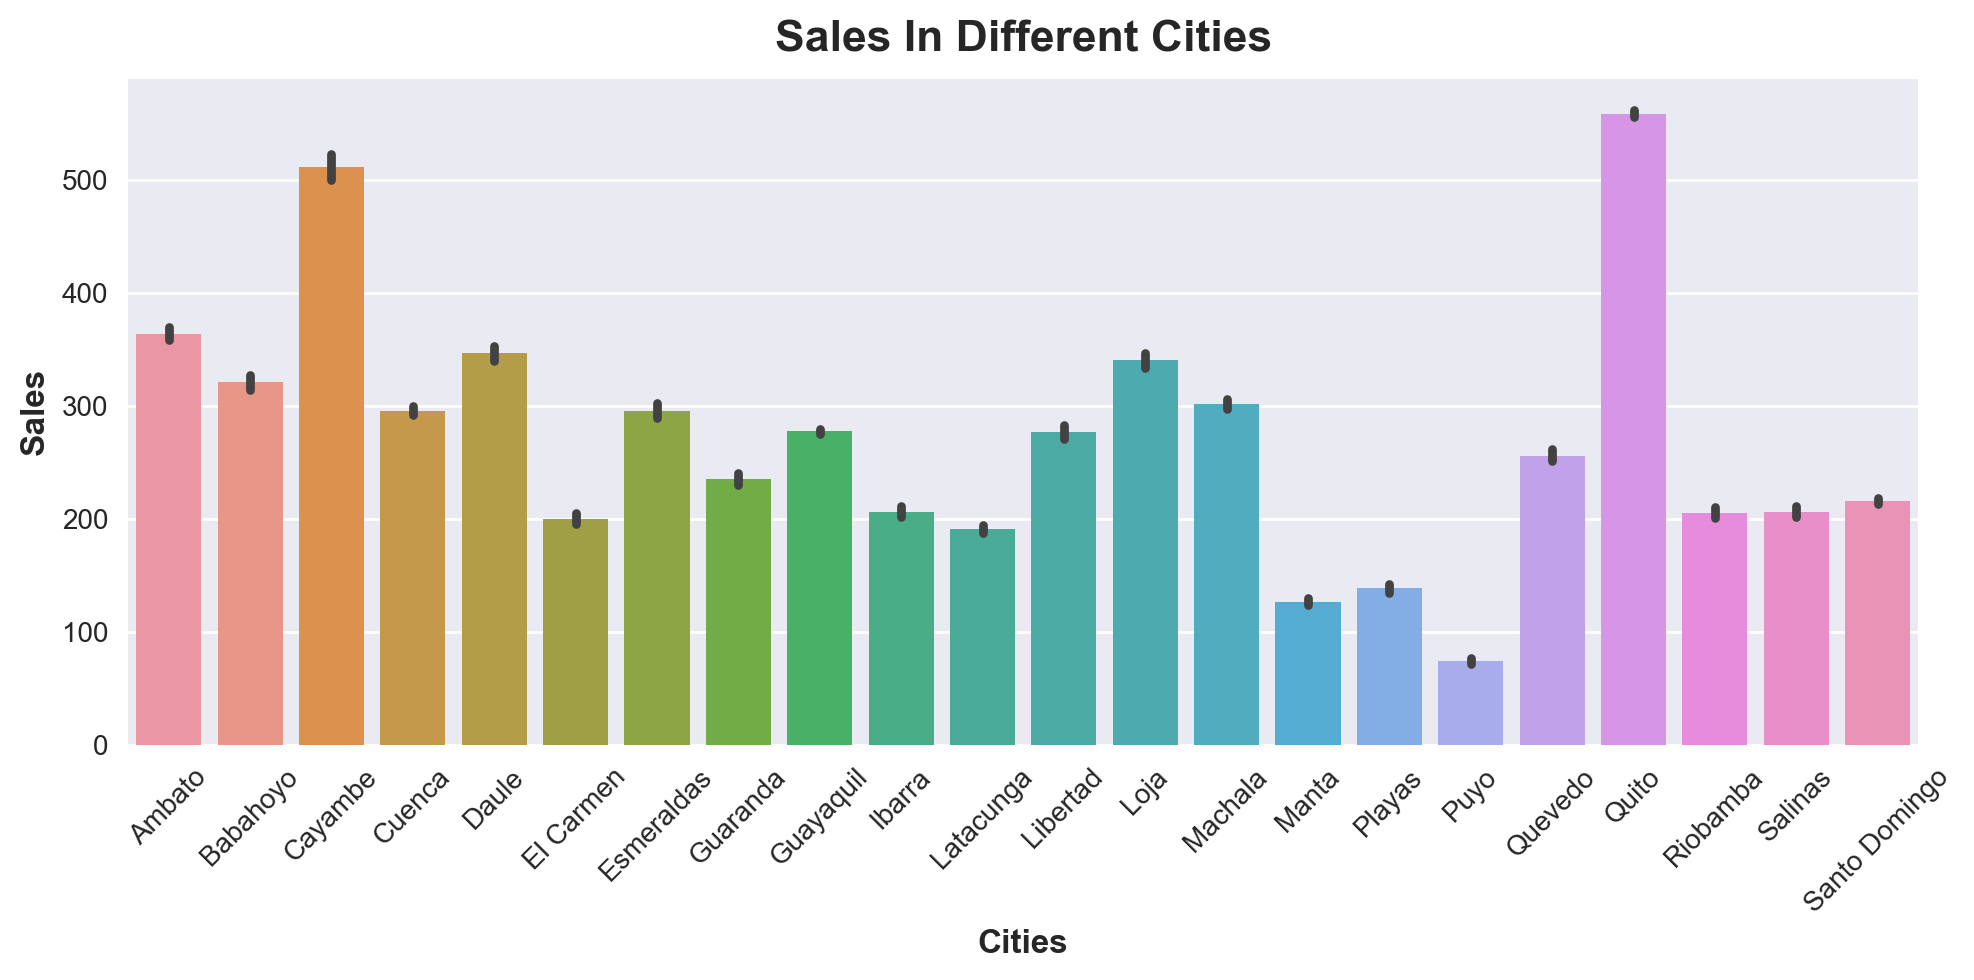

In [51]:
# Compare the sales in different cities

plt.figure(figsize=(10,5))
sns.barplot(x='city', y='sales', data=train_merged)
plt.title('Sales In Different Cities')
plt.xlabel('Cities')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

The plot above shows that stores in Quito are making more sales than stores in other cities.

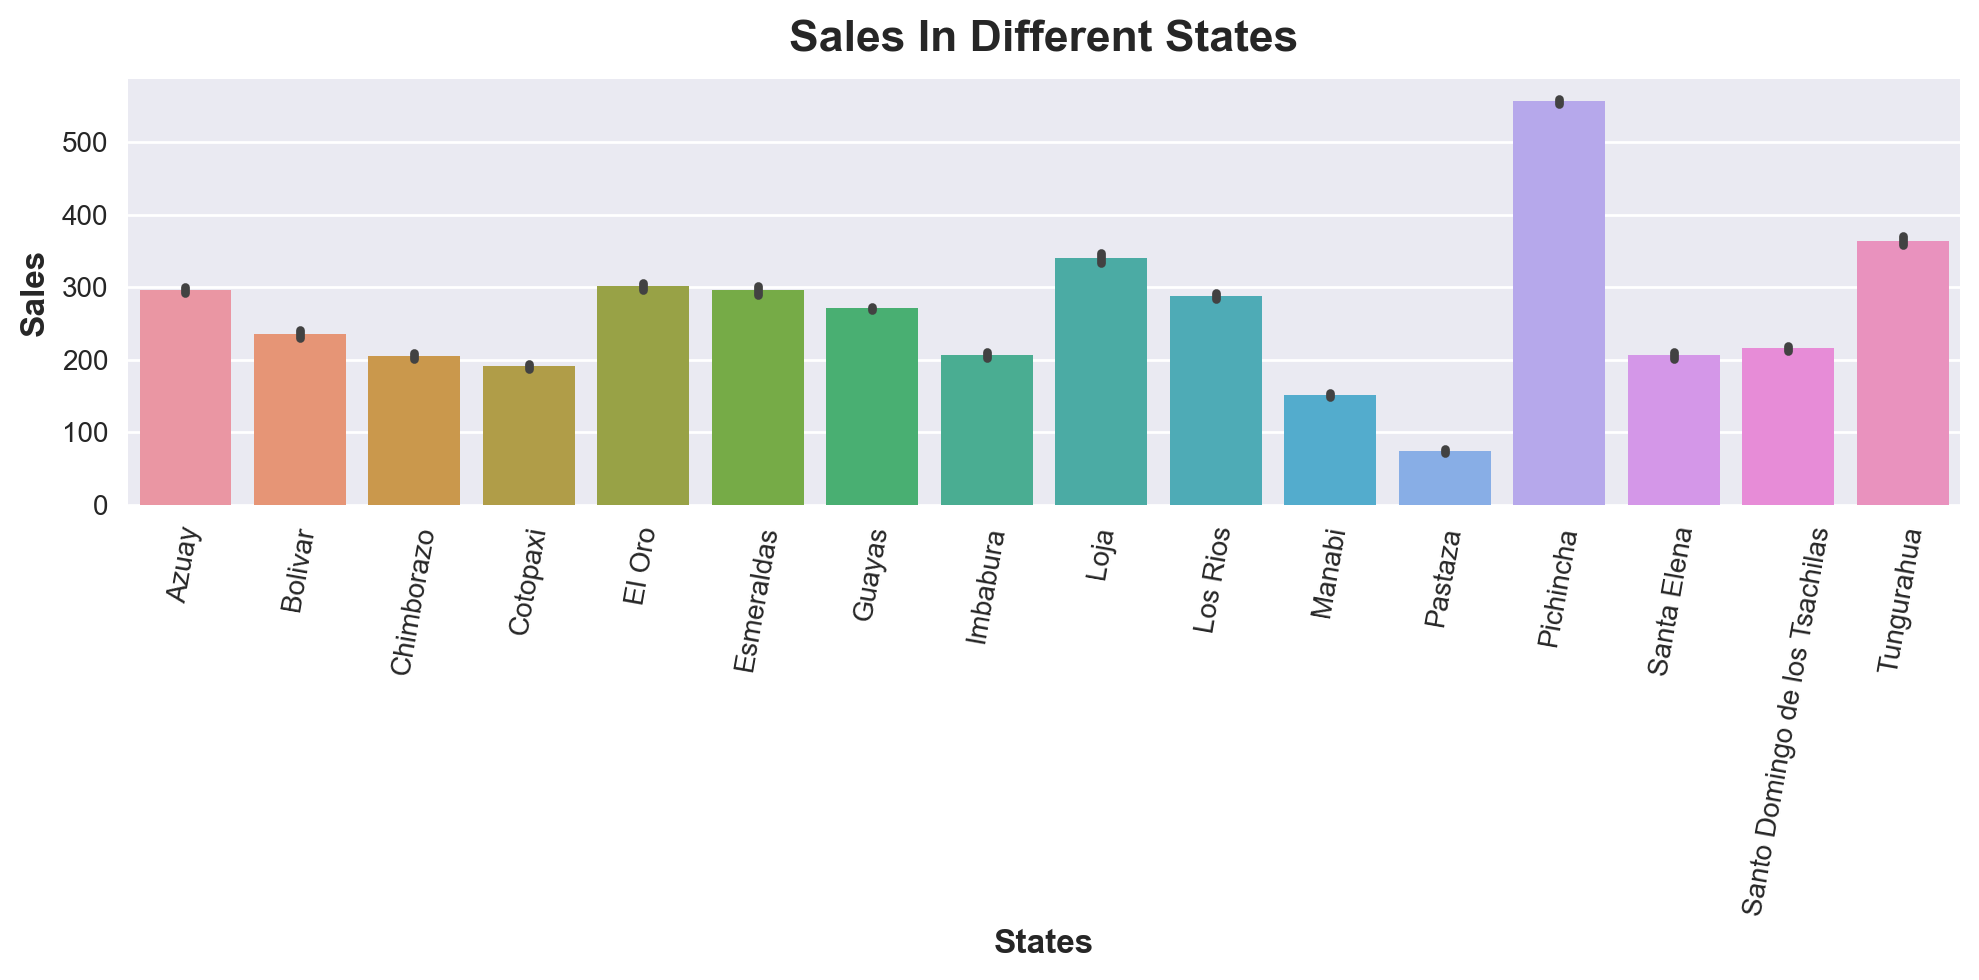

In [52]:
# Compare the sales in different states

plt.figure(figsize=(10,5))
sns.barplot(x='state', y='sales', data=train_merged)
plt.title('Sales In Different States')
plt.xlabel('States')
plt.ylabel('Sales')
plt.xticks(rotation = 80)
plt.show()

The plot above shows that stores in Pichincha are making more sales than stores in other states.

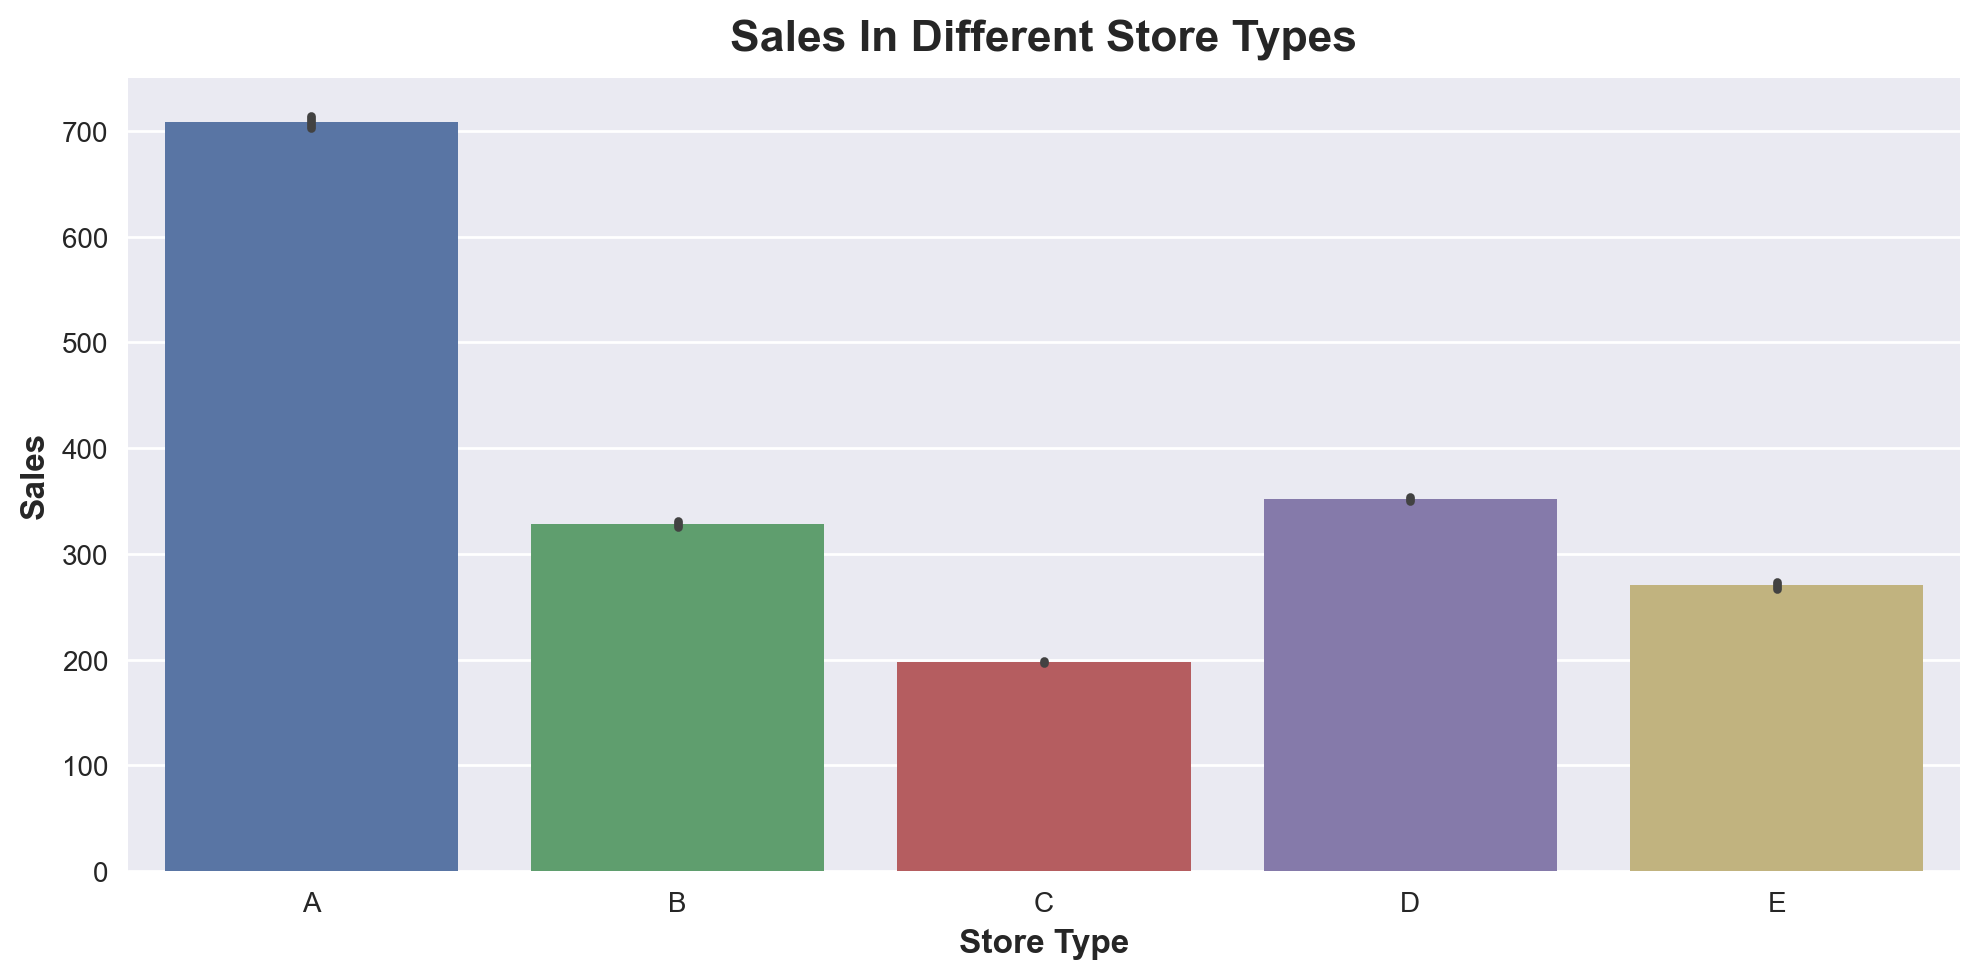

In [53]:
# Compare the sales in different store types

store_types = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', y='sales', data=train_merged, order=store_types)
plt.title('Sales In Different Store Types')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

The plot above shows that stores in Store type A are making more sales than stores in other store types.

### Question 5

Are sales affected by promotions, oil prices and holidays?

Text(0, 0.5, 'Sales')

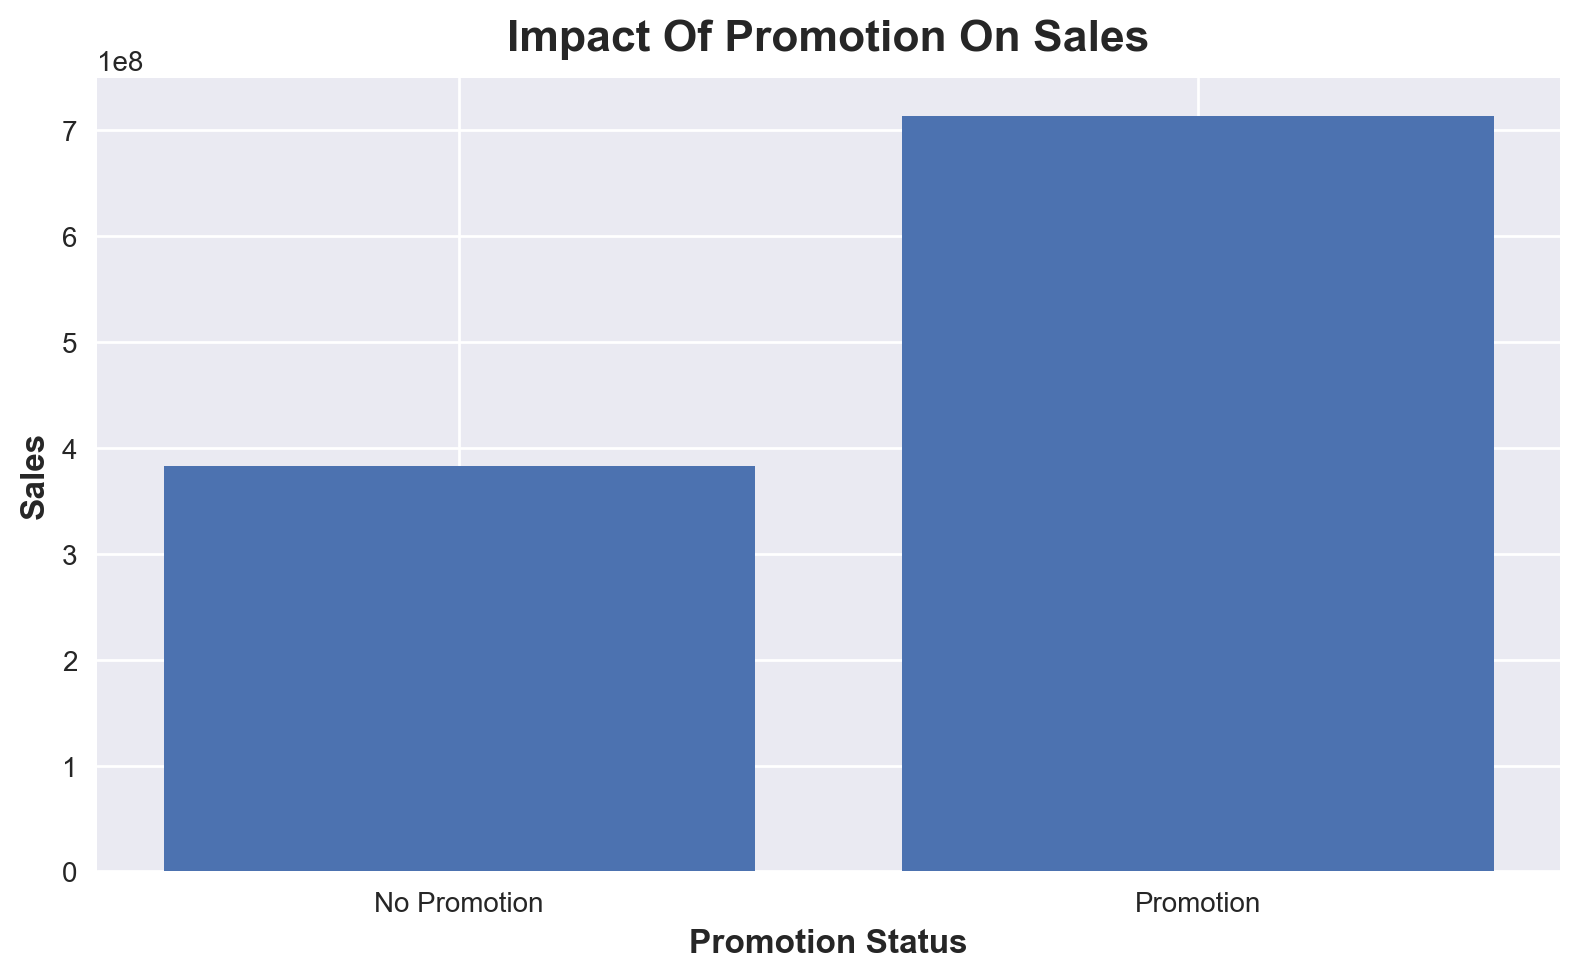

In [54]:
# Identify families with at least one item on promotion and families with no item on promotion
train_merged['onpromotion'] = train_merged['onpromotion'].apply(lambda x: 'No Promotion' if x == 0 else 'Promotion')

# Group by promotion and sum the sales
x = train_merged.groupby(['onpromotion'], as_index=False).agg({'sales':'sum'})

# Plot the sales of promotion and non_promotion families)
plt.figure(figsize=(8,5))
plt.bar(x.onpromotion, x.sales)
plt.title('Impact Of Promotion On Sales')
plt.xticks((0,1))
plt.xlabel('Promotion Status')
plt.ylabel('Sales')

The plot above shows that sales are affected by promotion. Product families with items on promotion are being sold more than product families with no item on promotion.

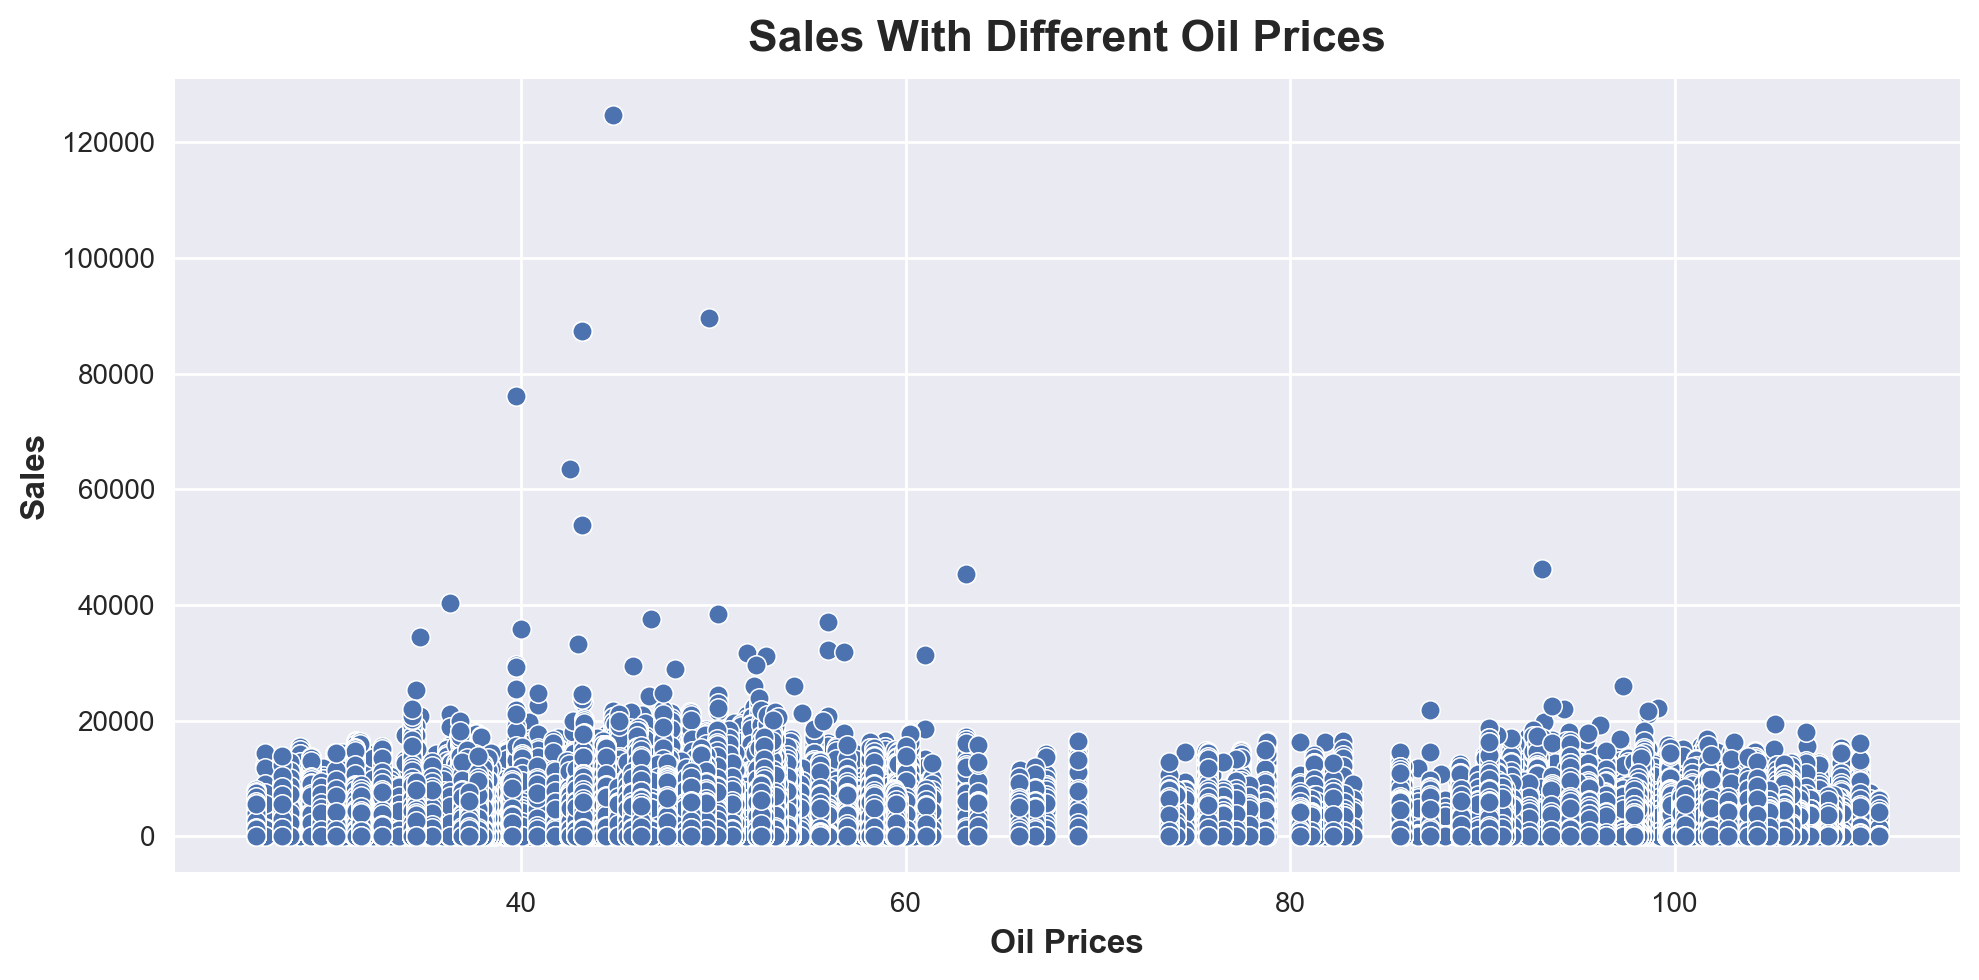

In [55]:
# Compare the sales with different oil prices

plt.figure(figsize=(10,5))
sns.scatterplot(x='oil_price', y='sales', data=train_merged)
plt.title('Sales With Different Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.show()

The plot above shows that sales are affected by the oil prices. As shown, there are more number of sales and more volume of sales at lower oil prices than at higher oil prices.

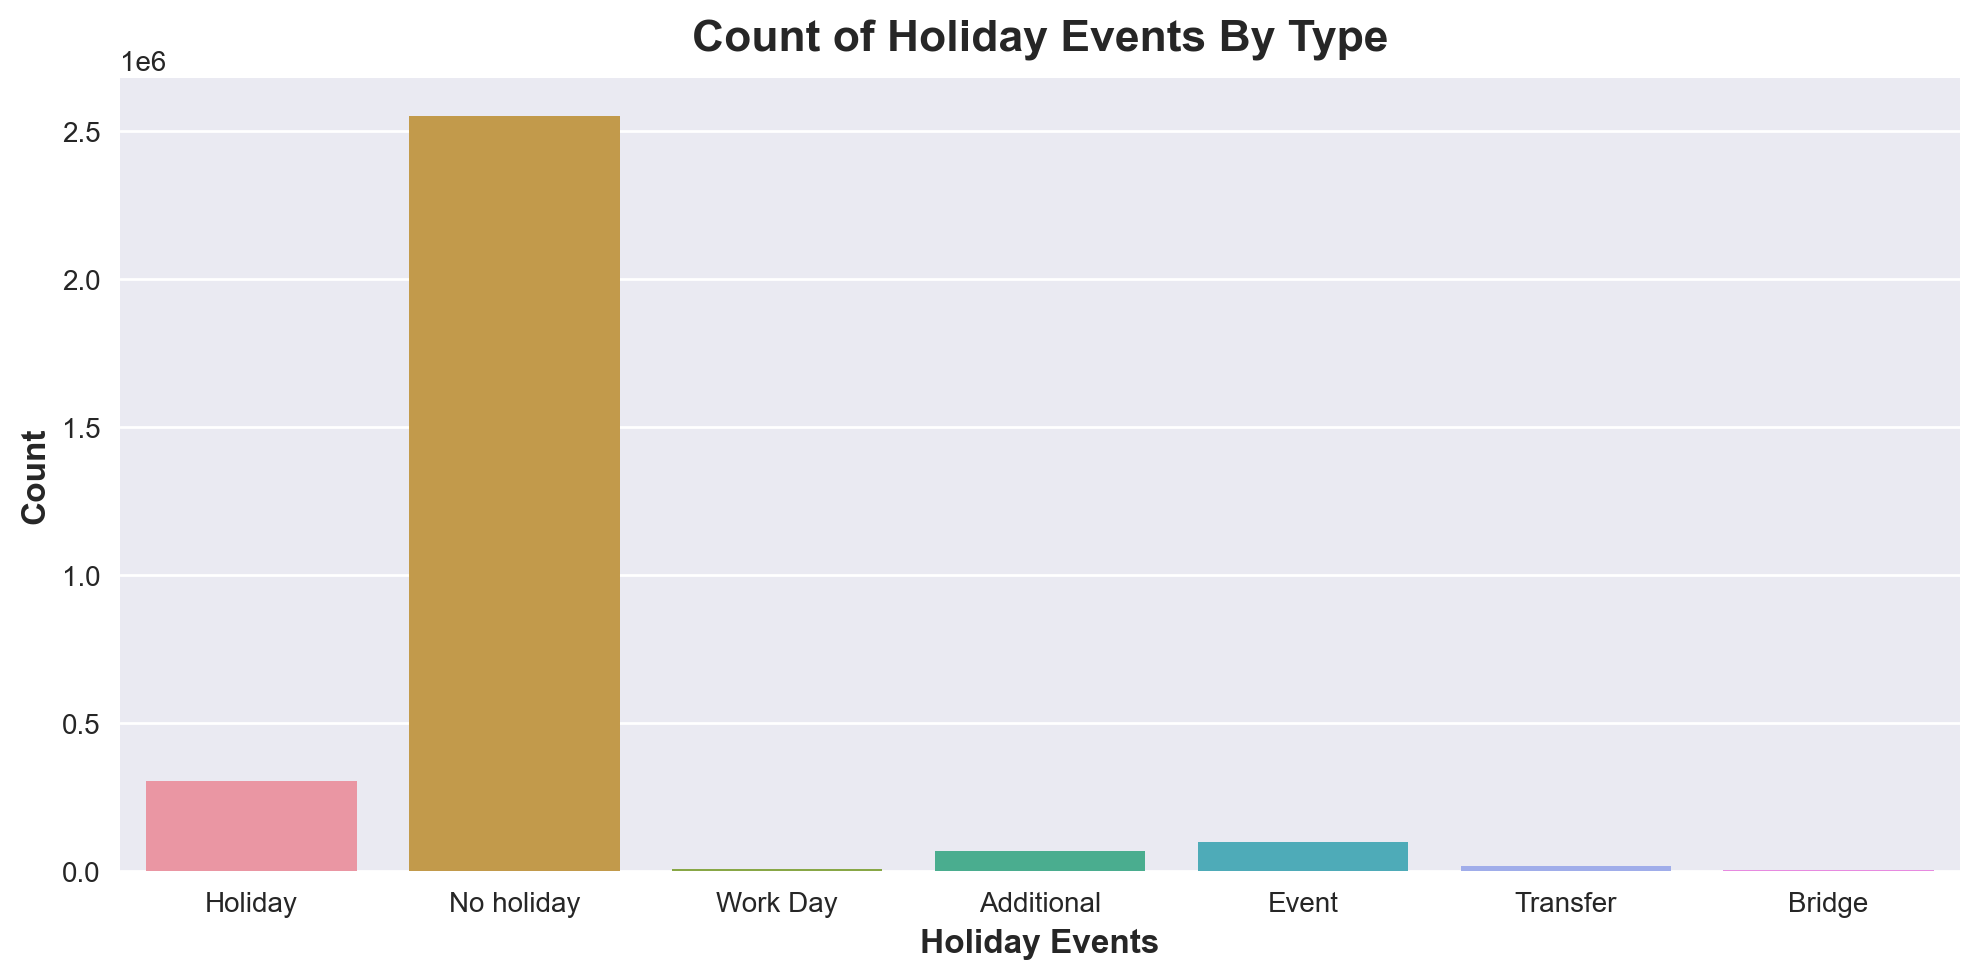

In [56]:
# Visualize the holiday events

plt.figure(figsize=(10,5))
sns.countplot(x='holiday_type', data=train_merged)
plt.title('Count of Holiday Events By Type')
plt.xlabel('Holiday Events')
plt.ylabel('Count')
plt.show()

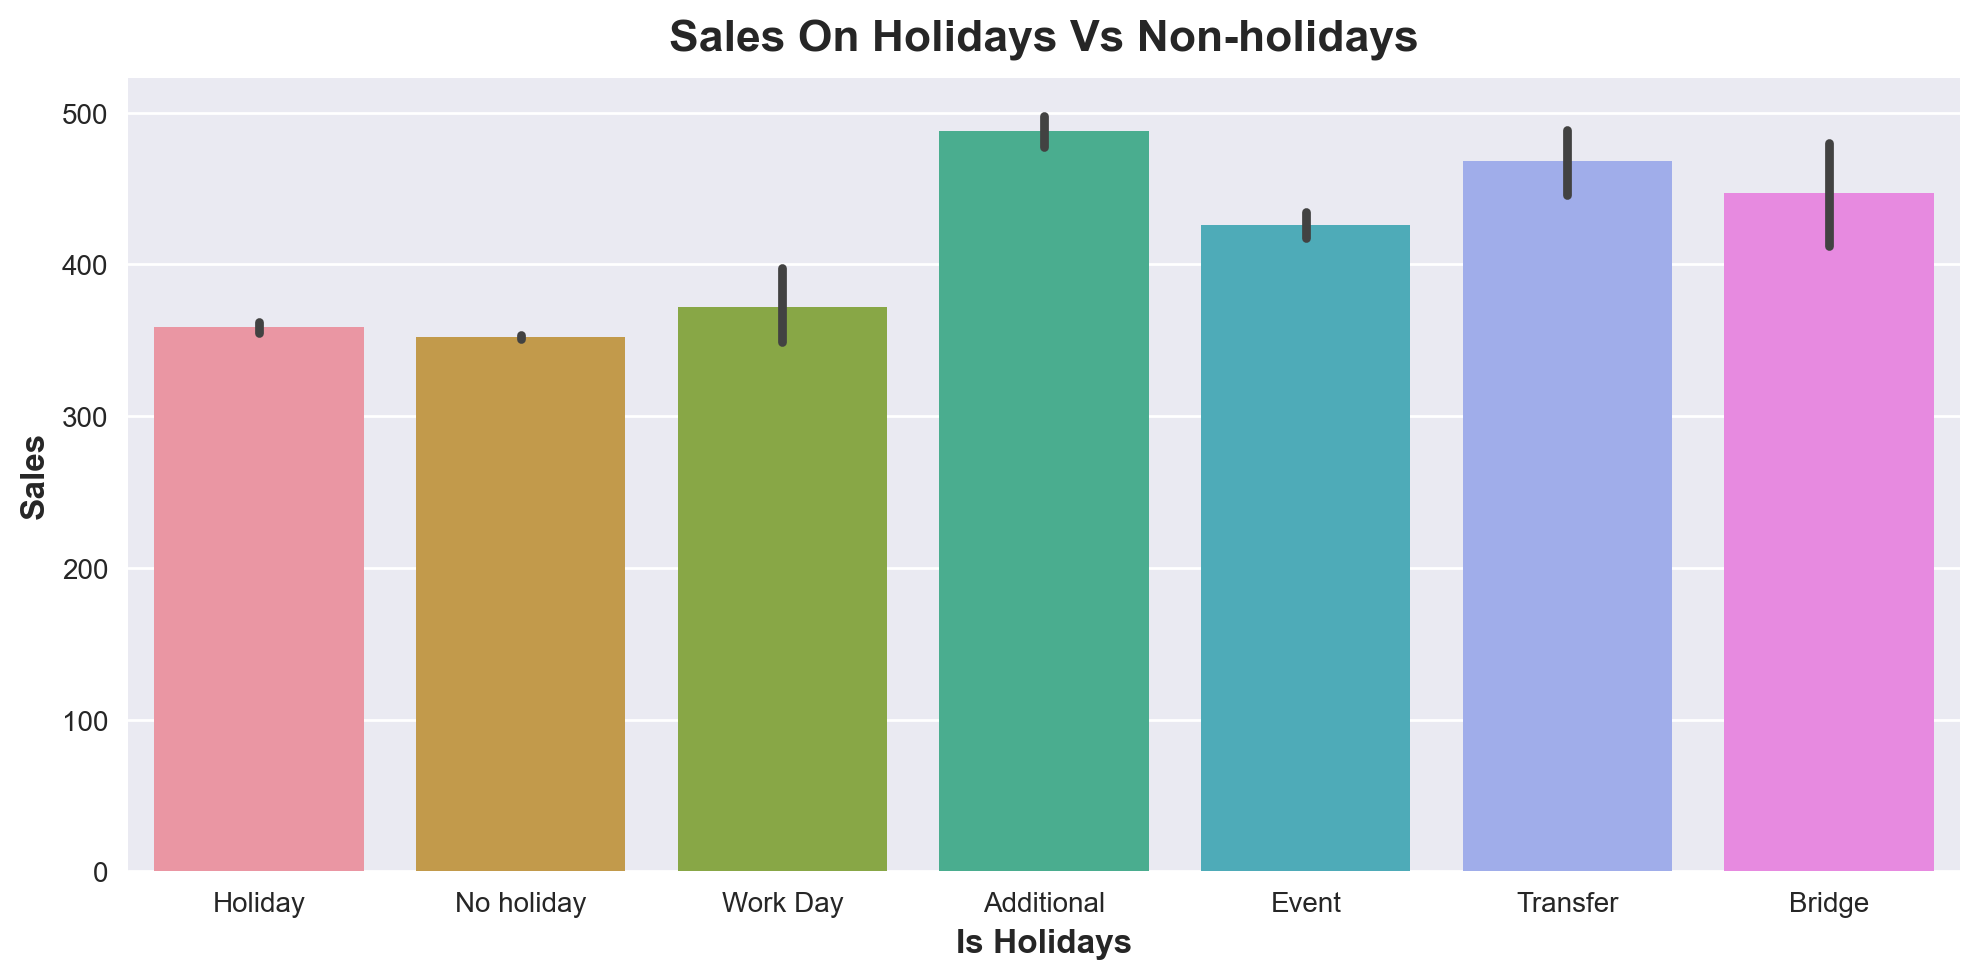

In [57]:
# Compare the sales on holidays with sales on non-holidays

plt.figure(figsize=(10,5))
sns.barplot(x='holiday_type', y='sales', data=train_merged)
plt.title('Sales On Holidays Vs Non-holidays')
plt.xlabel('Is Holidays')
plt.ylabel('Sales')
plt.show()

There are more sales during holidays than when there are no holidays. This is because more people are free to go out for shopping during holidays than when there is no holiday and they have to be at work or school.

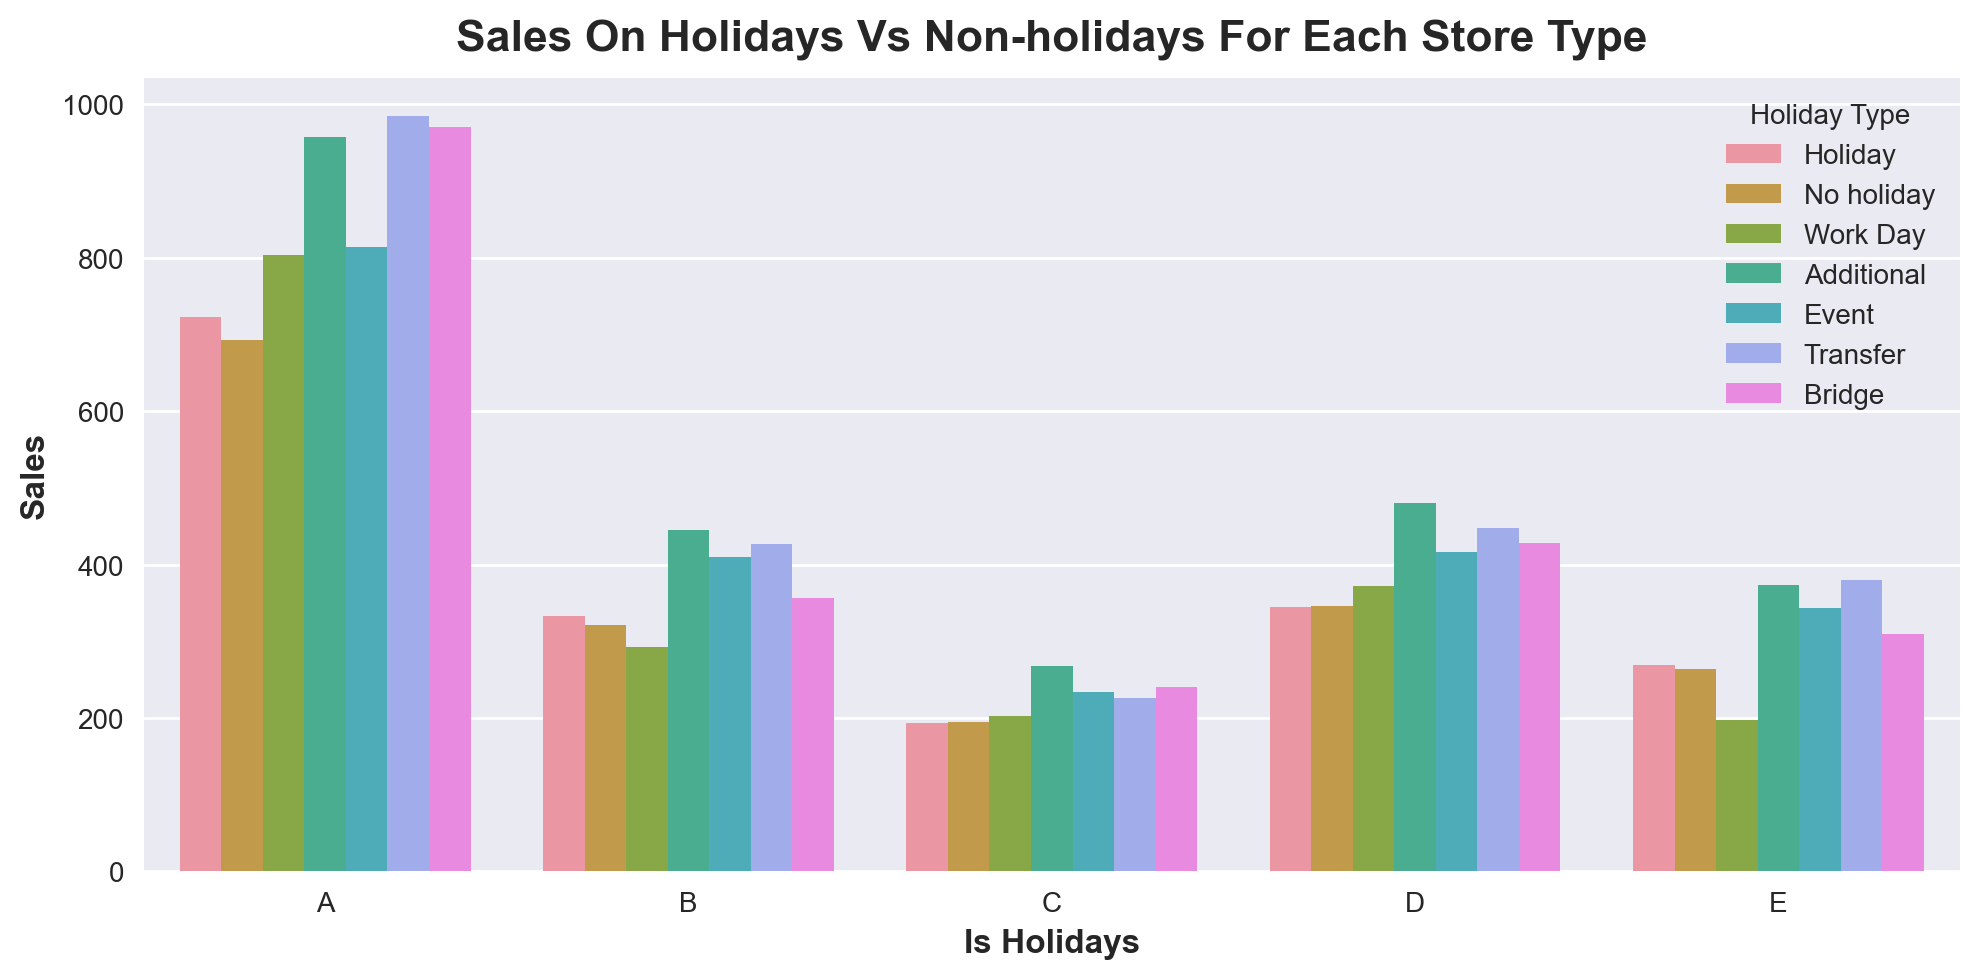

In [58]:
# Compare the sales on holidays with sales on non-holidays for the different store types

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', hue='holiday_type', y='sales', data=train_merged, ci=None, order=store_types)
plt.title('Sales On Holidays Vs Non-holidays For Each Store Type')
plt.xlabel('Is Holidays')
plt.ylabel('Sales')
plt.legend(title='Holiday Type')
plt.show()

There is no signicant impact of holidays on the sales made.

### Question 6

What analysis can we get from the date and its extractable features?

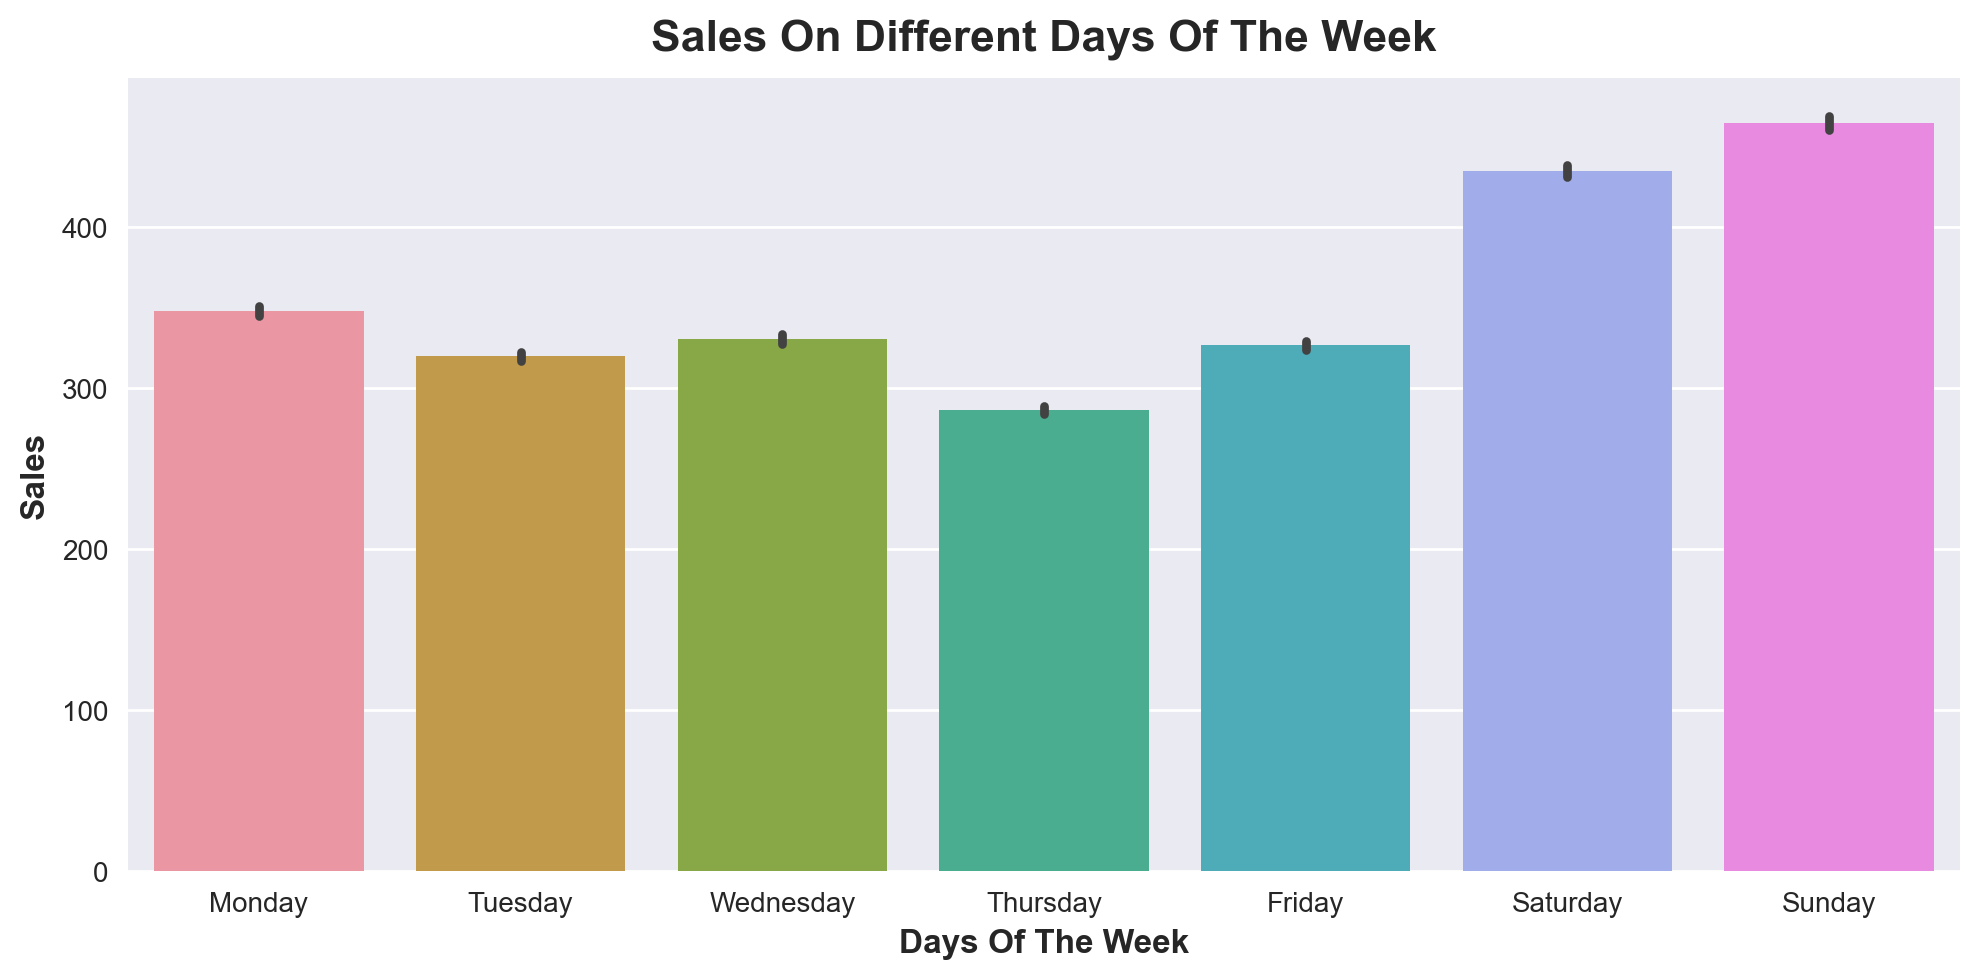

In [59]:
# From the date and its extractable features, the average sales on different days of the week can be analyzed

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10,5))
sns.barplot(x='dayname', y='sales', data=train_merged, order=days)
plt.title('Sales On Different Days Of The Week')
plt.xlabel('Days Of The Week')
plt.ylabel('Sales')
plt.show()

From the date and its extractable features, we can observe the sales according to the days of the week. As shown above, there are more sales during the weekends, with peak sales on Sundays.

### Question 7

What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

### Question 8

What is the total sales made each year by the corporation?

In [60]:
# Group by year and sum of sales for each year

sales_per_year = train_merged.groupby(['year'], as_index=False).agg({'sales':'sum'})
sales_per_year

,year,sales
0,2013,1.424880e+08
1,2014,2.130044e+08
2,2015,2.438321e+08
3,2016,2.991820e+08
4,2017,1.980683e+08


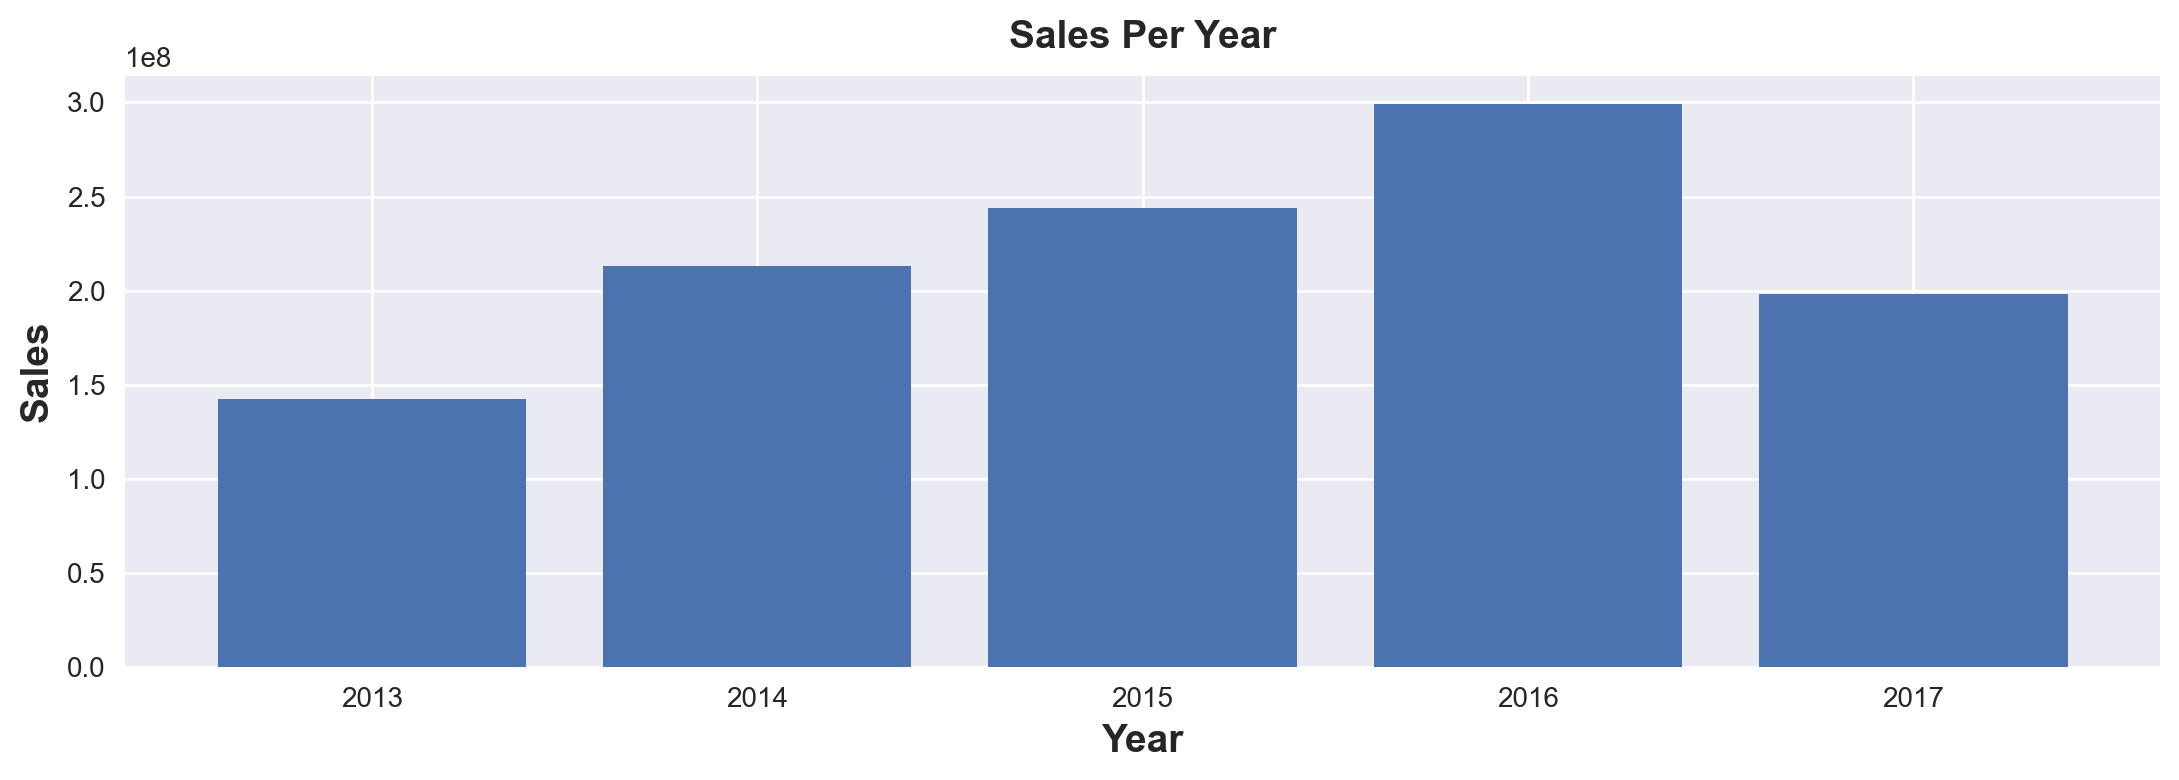

In [61]:
# Plot the sales made each year

plt.bar(sales_per_year.year, sales_per_year.sales)
plt.title('Sales Per Year',fontsize=14)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.show()

From the data provided, Corporation Favorita made it's lowest sales in 2013 and its highest sales in 2016.

# Feature Engineering

In [62]:
# Make a copy of the train_merged dataset on which to perform feature engineering

train_data = train_merged.copy()

In [63]:
# Change the index to ordinary column

train_data = train_data.reset_index()
train_data.head()

,date,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,...,oil_price,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
0,2013-01-01,0,1,AUTOMOTIVE,0.0,No Promotion,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
1,2013-01-01,1,1,BABY CARE,0.0,No Promotion,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
2,2013-01-01,2,1,BEAUTY,0.0,No Promotion,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
3,2013-01-01,3,1,BEVERAGES,0.0,No Promotion,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
4,2013-01-01,4,1,BOOKS,0.0,No Promotion,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday


### Drop Unnecessary columns

In [64]:
# Display all the columns of the dataset

train_data.columns

Index(['date', 'id', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'holiday_type', 'locale', 'locale_name', 'description',
       'transferred', 'oil_price', 'city', 'state', 'store_type', 'cluster',
       'year', 'month', 'dayofmonth', 'dayofweek', 'dayname'],
      dtype='object')

In [65]:
# Display random sample of 5 rows to see the contents of the columns

train_data.head()

,date,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,...,oil_price,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
0,2013-01-01,0,1,AUTOMOTIVE,0.0,No Promotion,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
1,2013-01-01,1,1,BABY CARE,0.0,No Promotion,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
2,2013-01-01,2,1,BEAUTY,0.0,No Promotion,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
3,2013-01-01,3,1,BEVERAGES,0.0,No Promotion,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday
4,2013-01-01,4,1,BOOKS,0.0,No Promotion,0.0,Holiday,National,Ecuador,...,93.139999,Quito,Pichincha,D,13,2013,1,1,1,Tuesday


In [66]:
# Drop some columns and display the dataset

columns_to_drop = ['id', 'store_nbr', 'locale', 'locale_name', 'description', 'transferred', 'state', 'store_type', 'cluster', 'month', 'dayofmonth', 'dayofweek', 'dayname']

train_data = train_data.drop(columns_to_drop, axis=1)
train_data.head()

,date,family,sales,onpromotion,transactions,holiday_type,oil_price,city,year
0,2013-01-01,AUTOMOTIVE,0.0,No Promotion,0.0,Holiday,93.139999,Quito,2013
1,2013-01-01,BABY CARE,0.0,No Promotion,0.0,Holiday,93.139999,Quito,2013
2,2013-01-01,BEAUTY,0.0,No Promotion,0.0,Holiday,93.139999,Quito,2013
3,2013-01-01,BEVERAGES,0.0,No Promotion,0.0,Holiday,93.139999,Quito,2013
4,2013-01-01,BOOKS,0.0,No Promotion,0.0,Holiday,93.139999,Quito,2013


### Data Splitting

The dataset will be splitted to training and validation sets using the time-based split. This will be done based on the year.

In [67]:
# List the years in the dataset

train_data['year'].unique()

array([2013, 2014, 2015, 2016, 2017])

In [68]:
# Establish the years for the training set and validation set
train_years = [2013, 2014, 2015, 2016]
val_year = [2017]

# Obtain the training set and validation set
train_set = train_data.loc[train_data['year'].isin(train_years)]
val_set = train_data.loc[train_data['year'].isin(val_year)]

# Print the shape of the training set and validation set
train_set.shape, val_set.shape

((2642706, 9), (411642, 9))

In [69]:
# Obtain the categorical columns and numerical columns

cat_columns = ['family', 'onpromotion', 'holiday_type', 'city']
num_columns = ['sales', 'transactions', 'oil_price']

### Feature Encoding

In [155]:
# Create an encoder object using OneHotEncoder

encoder = OneHotEncoder(sparse=False)

In [149]:
# Use OneHotEncoder to encode the categorical columns of X_train
encoder.fit(train_set[cat_columns])
train_set_cat_encoded = encoder.transform(train_set[cat_columns]).tolist()
train_set[cat_columns] = pd.DataFrame(X_train_cat_encoded, columns=encoder.get_feature_names_out())

# View the encoded X_train DataFrame
X_train_cat_encoded_df.head()



MemoryError: Unable to allocate 1.26 GiB for an array with shape (2642706, 64) and data type float64

In [144]:
# Fit and transform the numerical columns of the val set
val_set[cat_columns] = encoder.fit_transform(val_set[[cat_columns]])

# View the DataFrame
val_set.head()

KeyError: "None of [Index([('family', 'onpromotion', 'holiday_type', 'city')], dtype='object')] are in the [columns]"

### Feature Scaling

In [100]:
# Create a scaler object using StandardScaler

scaler = StandardScaler()

In [140]:
# Fit and transform the numerical columns of the train set
train_set[num_columns] = scaler.fit_transform(train_set[num_columns])

# View the DataFrame
train_set.head()

,date,family,sales,onpromotion,transactions,holiday_type,oil_price,city,year
0,2013-01-01,AUTOMOTIVE,-0.320272,No Promotion,-1.474507,Holiday,0.849157,Quito,2013
1,2013-01-01,BABY CARE,-0.320272,No Promotion,-1.474507,Holiday,0.849157,Quito,2013
2,2013-01-01,BEAUTY,-0.320272,No Promotion,-1.474507,Holiday,0.849157,Quito,2013
3,2013-01-01,BEVERAGES,-0.320272,No Promotion,-1.474507,Holiday,0.849157,Quito,2013
4,2013-01-01,BOOKS,-0.320272,No Promotion,-1.474507,Holiday,0.849157,Quito,2013


In [152]:
# Fit and transform the numerical columns of the val set
val_set[num_columns] = scaler.fit_transform(val_set[num_columns])

# View the DataFrame
val_set.head()

,date,family,sales,onpromotion,transactions,holiday_type,oil_price,city,year
2642706,2017-01-01,AUTOMOTIVE,-0.35422,No Promotion,-1.724057,Holiday,0.95101,Quito,2017
2642707,2017-01-01,BABY CARE,-0.35422,No Promotion,-1.724057,Holiday,0.95101,Quito,2017
2642708,2017-01-01,BEAUTY,-0.35422,No Promotion,-1.724057,Holiday,0.95101,Quito,2017
2642709,2017-01-01,BEVERAGES,-0.35422,No Promotion,-1.724057,Holiday,0.95101,Quito,2017
2642710,2017-01-01,BOOKS,-0.35422,No Promotion,-1.724057,Holiday,0.95101,Quito,2017


In [102]:
# Concatenate the encoded X_train DataFrame and the scaled X_train DataFrame to have the unbalanced X_train DataFrame

X_train = pd.concat([X_train_cat_encoded_df, X_train_num_scaled_df.set_axis(X_train_cat_encoded_df.index)], axis=1)
X_train.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_SEAFOOD,onpromotion_Promotion,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_No holiday,holiday_type_Transfer,holiday_type_Work Day,transactions,oil_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.474507,0.849157
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.474507,0.849157
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.474507,0.849157
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.474507,0.849157
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.474507,0.849157


In [103]:
# Concatenate the encoded X_val DataFrame and the scaled X_val DataFrame to have the ready X_val DataFrame

X_val = pd.concat([X_val_cat_encoded_df, X_val_num_scaled_df.set_axis(X_val_cat_encoded_df.index)], axis=1)
X_val.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,onpromotion_Promotion,holiday_type_Event,holiday_type_Holiday,holiday_type_No holiday,holiday_type_Transfer,transactions,oil_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.724057,0.95101
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.724057,0.95101
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.724057,0.95101
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.724057,0.95101
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.724057,0.95101


# Modelling

The following models will be built and evaluated:
1. Linear Regression

2. XGBoost

3. CatBoost

4. ARIMA

5. SARIMA

In [112]:

# def evaluate_time_series_models(data, date_column, target_column):
#     # Assuming you have your time series data in a DataFrame 'data'
#     # Replace 'date_column' with the column containing date/time and 'target_column' with the target variable column name
#     data[date_column] = pd.to_datetime(data[date_column])
#     data.set_index(date_column, inplace=True)
#     target = data[target_column]

#     # Splitting the data into training and testing sets (you can adjust the split ratio as per your requirement)
#     train_size = int(len(target) * 0.8)
#     train, test = target[:train_size], target[train_size:]

# Initialize model names and corresponding models
model_names = ['Linear Regression', 'XGBoost', 'CatBoost', 'ARIMA', 'SARIMA']
models = [LinearRegression(), xgb.XGBRegressor(), CatBoostRegressor(), ARIMA(train, order=(1, 0, 0)),
          SARIMAX(train, order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))]

# Create a DataFrame to store the evaluation results
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'RMSLE', 'MSLE'])

for model_name, model in zip(model_names, models):
    if model_name in ['ARIMA', 'SARIMA']:
        # Fit the ARIMA or SARIMA model
        model_fit = model.fit()

        # Make predictions
        model_preds = model_fit.forecast(steps=len(test))
    else:
        # Fit other models
        model.fit(np.arange(len(train)).reshape(-1, 1), train)

        # Make predictions
        model_preds = model.predict(np.arange(len(test)).reshape(-1, 1))

    # Calculate evaluation metrics
    mse = mean_squared_error(test, model_preds)
    rmse = np.sqrt(mse)
    rmsle = np.sqrt(mean_squared_log_error(test, model_preds))
    msle = mean_squared_log_error(test, model_preds)

    # Append the results to the DataFrame
    results = results.append({'Model': model_name, 'MSE': mse, 'RMSE': rmse, 'RMSLE': rmsle, 'MSLE': msle},
                             ignore_index=True)

return results

# Assuming you have your time series data in a DataFrame 'data' with columns 'Date' and 'Target'
# Adjust the column names accordingly
results = evaluate_time_series_models(train_merged, date_column='Date', target_column='y_val')
results

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [113]:
# Initialize the model
catboost_model = CatBoostRegressor()

# Fit the model
catboost_model.fit(np.arange(len(X_train)).reshape(-1, 1), X_train)

# Make predictions
catboost_preds = catboost_model.predict(np.arange(len(X_val)).reshape(-1, 1))

# Calculate evaluation metrics
mse_catboost = mean_squared_error(X_val, catboost_preds)
rmse_catboost = np.sqrt(mse_catboost)
rmsle_catboost = np.sqrt(mean_squared_log_error(X_val, catboost_preds))
msle_catboost = mean_squared_log_error(X_val, catboost_preds)

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/target/data_providers.cpp:612: Currently only multi-regression, multilabel and survival objectives work with multidimensional target

In [ ]:
# Make predictions on the validation set

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

In [ ]:
plt.plot(val.index, predictions, label='AR Forecast')
plt.xlabels('date')
plt.ylabels('sales')
plt.title('AutoRegressive (AR) Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# Create an empty DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'RMSLE', 'MSLE'])

# Calculate evaluation metrics
mse = mean_squared_error(val, predictions)
rmse = np.sqrt(mse).round(2)

# Create a new row for the evaluation metrics of ARIMA model on the results DataFrame
ARIMA_results = pd.DataFrame([['ARIMA', 'mse', 'rmse', '-', '-']], columns=['Model', 'MSE', 'RMSE', 'RMSLE', 'MSLE'])
results = results.append(ARIMA_results, ignore_index=True)

### SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(1,1,1), seasonal_order = (1,1,1,12))
model_fit = model.fit()
model_fit.summary()

# Hyperparameter Tuning

# Prediction